# #MeToo movement impact on women's voices in the newspapers

## Table of contents

1. [Introduction](#Introduction)
2. [Data preprocessing](#Data-preprocessing)
3. [Imports](#Imports) 
    1. [Libraries](#Libraries)
    2. [Dataset](#Dataset)
    3. [Dictionaries](#Dictionaries)
4. [Data exploration](#Data-exploration)
    1. [Number of quotations by gender from 2015 to 2020](#Number-of-quotations-by-gender-from-2015-to-2020)
    2. [Number of occurrences by gender from 2015 to 2020](#Number-of-occurrences-by-gender-from-2015-to-2020)
    3. [Number of speakers by gender from 2015 to 2020](#Number-of-speakers-by-gender-from-2015-to-2020)
    4. [Lexical fields](#Lexical-fields)
    5. [Age of the speakers](#Age-of-the-speakers)
    6. [Main occupations represented](#Main-occupations-represented)
    7. [#MeToo breatdh in the news](##MeToo-breadth-in-the-news)
5. [Observational study](#Observational-study)
    1. [Data preparation](#Data-preparation)
    2. [Create a balanced dataset](#Create-a-balanced-dataset)
        1. [Pair identical speakers](#Pair-identical-speakers)
        2. [Pair non-identical speakers](#Pair-non-identical-speakers)
            1. [Propensity score calculation](#Propensity-score-calculation)
            2. [Matching by gender](#Matching-by-gender)
            3. [Matching by category of occupation](#Matching-by-category-of-occupation)
    3. [Results](#Results)
        1. [Comparison between men and women speakers in general](#Comparison-between-men-and-women-speakers-in-general)
            1. [Take a look at the data](#Take-a-look-at-the-data)
            2. [Statistical tests by gender](#Statistical-tests-by-gender)
            3. [A first look at the occupations...](#A-first-look-at-the-occupations...)
        2. [Comparison between men and women speakers by category of occupation](#Comparison-between-men-and-women-speakers-by-category-of-occupation)
            1. [Proportion number of quotes of a specific occupations among others](#Proportion-number-of-quotes-of-a-specific-occupations-among-others)
            2. [Overview of the occupation categories](#Overview-of-the-occupation-categories)
                1. [Geometric mean of the number of quotations for all occupations before and after #MeToo for each gender](#Geometric-mean-of-the-number-of-quotations-for-all-occupations-before-and-after-#MeToo-for-each-gender)
                2. [Geometric mean of the number of occurences of quotation for all occupations before and after #MeToo for each gender](#Geometric-mean-of-the-number-of-occurences-of-quotation-for-all-occupations-before-and-after-#MeToo-for-each-gender)
                3. [Median of the number of quotations for all occupations before and after #MeToo for each gender](#Median-of-the-number-of-quotations-for-all-occupations-before-and-after-#MeToo-for-each-gender)
                4. [Median of the number of occurences for all occupations before and after #MeToo for each gender](#Median-of-the-number-of-occurences-for-all-occupations-before-and-after-#MeToo-for-each-gender)
            6. [Geometric mean of the number of quotations per occupation and per gender](#Geometric-mean-of-the-number-of-quotations-per-occupation-and-per-gender)
            7. [Median of the number of quotations per occupation and per gender](#Median-of-the-number-of-quotations-per-occupation-and-per-gender)
            8. [Statistical tests by both occupation and gender](#Statistical-tests-by-both-occupation-and-gender)
6. [Discussion](#Discussion)
    1. [Matching assessment](#Matching-assessment)
7. [Conclusion](#Conclusion)

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.

## Data preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We splitted the dataset of 2017 in two: January-October (date of the emergence of the movement) and October-December. After that, we removed the date, still only knowing the year of the dataset will be enough for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We removed from the original datasets all the quotations for which multiple QIDS are linked: indeed, we cannot now which of the homonyms is the real speaker. Then we merged our dataset with the attributes of the speakers (thanks to their `qids`), and we decided to keep the following attributes: `gender`, `date_of_birth`, `occupation` and `academic_degree`. We did not kept `ethnic_group` neither `religion` since they are very rarely known. For each dataset, we computed the age of the speaker the year of the quotation, and thus transformed the column `date_of_birth` by a column `age`. 


4. Then, we dropped all quotations for which one of its attribute is not known, since we will need all of them for our analyses. We also replaced all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The datasets are now reduced, and they are stored under .json.bz2 files and are named "observational-{year}". These files will be used for the [data exploration](#Data-exploration), and they follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- academic_degree: ndarray
```


5. In order to conduct the observational study, we created one single dataframe with all the quotes of all years. We added a column `year` to be able to still access the year of the quotation, and also a column `label`: if 0, the quotation has been said before the #MeToo movement, if 1, the quotation has been said after the #MeToo movement. This is the dataframe we will use for the [observational study](#Observational-study), and is stored under "'data_observational.json.bz2". 

The final dataset contains 1,761,820 entries and is following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- academic_degree: ndarray
 |-- label: int 0 or 1
 |-- year: int
```

The code for step 3, 4 and 5 is available [here](src/Create_data_obs_study.ipynb).

## Imports

### Libraries

In [1]:
#pandas/numpy
import pandas as pd
import numpy as np

#loading data
import bz2
import json

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import wordcloud
from PIL import Image
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#math operations
import math

#statistics
from scipy import stats
#from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin

#matching algorithm
import networkx as nx

#util functions 
from utils import gmean_occupations, visualize_by_occupation, quotes_by_gender, unique_speaker_per_gender, get_champlex

#count in collection
from collections import Counter

#warnings
import warnings
#ignore future warnings
#warnings.filterwarnings('ignore')

### Dataset


In [2]:
DATA_FOLDER = 'data/'

#Data by year
DATA_2015 = DATA_FOLDER+"observational-2015.json.bz2"
DATA_2016 = DATA_FOLDER+"observational-2016.json.bz2"
DATA_2017_BEFORE = DATA_FOLDER + "observational-2017-before.json.bz2"
DATA_2017_AFTER = DATA_FOLDER + "observational-2017-after.json.bz2"
DATA_2018 = DATA_FOLDER+"observational-2018.json.bz2"
DATA_2019 = DATA_FOLDER+"observational-2019.json.bz2"
DATA_2020 = DATA_FOLDER+"observational-2020.json.bz2"

#All data
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

In [3]:
quotes_2015 = pd.read_json(DATA_2015)
quotes_2016 = pd.read_json(DATA_2016)
quotes_2017_before = pd.read_json(DATA_2017_BEFORE)
quotes_2017_after = pd.read_json(DATA_2017_AFTER)
quotes_2018 = pd.read_json(DATA_2018)
quotes_2019 = pd.read_json(DATA_2019)
quotes_2020 = pd.read_json(DATA_2020)

### Dictionnaries

Since our project aims to focus on the representation of female speakers in the news depending on their profile, we needed to classify occupations into more global categories. Thus, we classified manually all occupations into more general categories, and we did the same for the academic degree.

In [4]:
WIKIDATA_LABELS = DATA_FOLDER + "wikidata_labels_descriptions_quotebank.csv.bz2"
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

In [5]:
wiki_labels = pd.read_csv(WIKIDATA_LABELS, compression='bz2', index_col='QID')

In [6]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [7]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

## Data exploration

In [8]:
quotes_2017 = pd.concat([quotes_2017_before, quotes_2017_after])

years = [2015, 2016, 2017, 2018, 2019, 2020]
quotes_years = [quotes_2015, quotes_2016, quotes_2017, quotes_2018, quotes_2019, quotes_2020]
years_detailed = [2015, 2016, 2017, 2017, 2018, 2019, 2020]
period_detailed = ['Before #MeToo', 'Before #MeToo', 'Before #MeToo',
                   'After #MeToo (short term)', 'After #MeToo (short term)', 
                   'After #MeToo (long term)','After #MeToo (long term)']
quotes_years_detailed= [quotes_2015, quotes_2016, quotes_2017_before, quotes_2017_after, 
                        quotes_2018, quotes_2019, quotes_2020]

In [9]:
for i in range(len(quotes_years_detailed)):
    quotes_years_detailed[i]['year']=years_detailed[i]
    quotes_years_detailed[i]['period']=period_detailed[i]

In [10]:
quotes_all = pd.concat(quotes_years_detailed, ignore_index=True)

In [11]:
quotes_before = pd.concat([quotes_2015, quotes_2016, quotes_2017_before], ignore_index=True)
quotes_after_shortterm = pd.concat([quotes_2017_after, quotes_2018], ignore_index=True)
quotes_after_longterm = pd.concat([quotes_2019, quotes_2020], ignore_index=True)
quotes_after = pd.concat([quotes_after_shortterm, quotes_after_longterm], ignore_index=True)

In [12]:
periods = ['Before #MeToo', 'After #MeToo (short term)', 'After #MeToo (long term)']
quotes_periods = [quotes_before, quotes_after_shortterm, quotes_after_longterm]

In [13]:
quotes_before.head()

,quotation,speaker,qids,numOccurrences,gender,age,occupation,academic_degree,year,period
0,I am convinced that this conflict won't be sol...,Angela Merkel,Q567,1,female,61,"[politician, physicist, statesperson, chemist]",[doctorate],2015,Before #MeToo
1,agreed that the E.U. should take further measu...,Angela Merkel,Q567,6,female,61,"[politician, physicist, statesperson, chemist]",[doctorate],2015,Before #MeToo
2,Germany will continue to do everything to supp...,Angela Merkel,Q567,1,female,61,"[politician, physicist, statesperson, chemist]",[doctorate],2015,Before #MeToo
3,There has already been voluntary debt forgiven...,Angela Merkel,Q567,1,female,61,"[politician, physicist, statesperson, chemist]",[doctorate],2015,Before #MeToo
4,They can be lifted if the reasons why they wer...,Angela Merkel,Q567,1,female,61,"[politician, physicist, statesperson, chemist]",[doctorate],2015,Before #MeToo


### Number of quotations by gender from 2015 to 2020

In [14]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = False, others_grouped = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

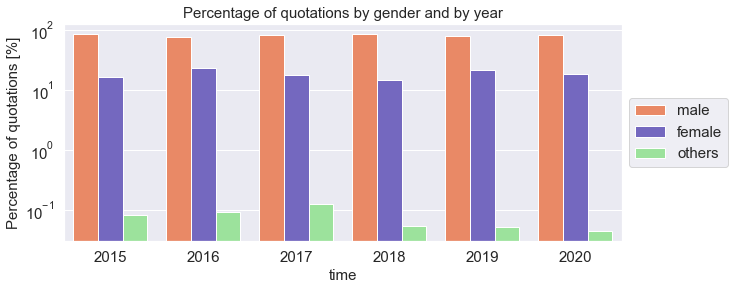

In [15]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, 
                 hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years,
                palette = {"male": "coral", "female": "slateblue", "others": "lightgreen"})
ax.set(yscale="log");
ax.set_ylabel('Percentage of quotations [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of quotations by gender and by year', fontsize = 15, fontweight = 15);
ax.tick_params(labelsize=15)

**Be careful, this plot has log scale in y-axis.**

Plotting the percentage of citations by gender for each year from 2015 to 2020, we can clearly see that the 'male' gender is the most represented and is the one for which most citations are related. We can also see that the proportion of speakers with a gender other than 'male' or 'female' is really low. For this reason, and since our analysis will focus primarily on the 'female' gender and its differences from the 'male' gender, we will discard these speakers for further analysis.

In [16]:
#Drop the rows having a gender other than the 2 most represented 
for year, quotes in zip(years, quotes_years):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

In [17]:
for period, quotes in zip(periods, quotes_periods):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

Let's look at the percentage of quotations by gender for every year, now that we have only 'male' and 'female' genders.

In [18]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

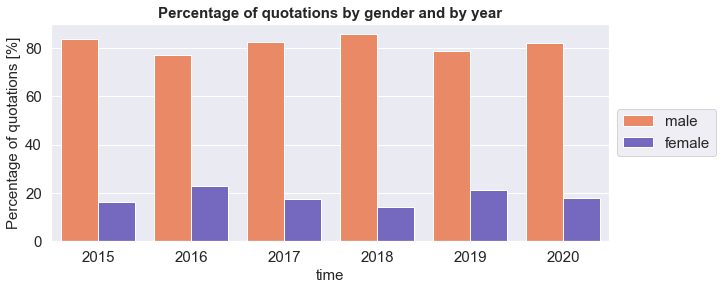

In [19]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], 
                 y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], 
                 data = quotes_by_gender_years,
                palette = {"male": "coral", "female": "slateblue"})
ax.set_ylabel('Percentage of quotations [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of quotations by gender and by year', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

Looking at this graph, we see a clear difference between the percentage of male and female citations. In fact, about 80% of all reported citations are by men. However, looking at women, we can see a slight increase in their percentage of citations over time.

Let's now take a closer look at the impact of the #MeToo movement by separating time into 3 categories:

- before #MeToo: January 2015 to October 2017.
- after #MeToo (short term): October 2017 to December 2018.
- after #MeToo (long term): January 2019 to December 2020.


In [20]:
by_gender_periods = []
for period, quotes in zip(periods, quotes_periods):
    by_gender_periods.append(quotes_by_gender(quotes, period, major_only = True))

quotes_by_gender_periods = pd.concat(by_gender_periods, ignore_index = True)

In [21]:
quotes_by_gender_periods

,gender,count,Occurrences,time
0,male,0.814335,0.820290,Before #MeToo
1,female,0.185665,0.179710,Before #MeToo
2,male,0.853006,0.888392,After #MeToo (short term)
3,female,0.146994,0.111608,After #MeToo (short term)
4,male,0.790363,0.814610,After #MeToo (long term)
5,female,0.209637,0.185390,After #MeToo (long term)


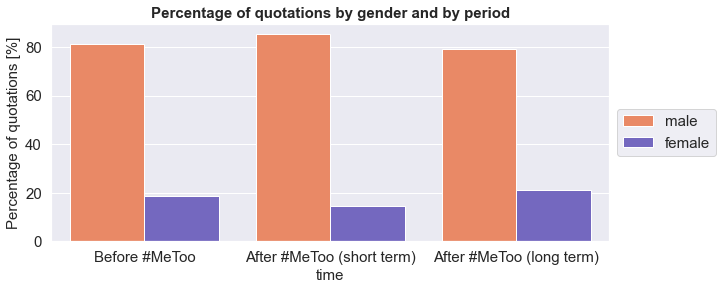

In [22]:
ax = sns.barplot(x = quotes_by_gender_periods['time'],
                 y = quotes_by_gender_periods['count']*100, hue = quotes_by_gender_periods['gender'], 
                 data = quotes_by_gender_periods,
                palette = {"male": "coral", "female": "slateblue"})
ax.set_ylabel('Percentage of quotations [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of quotations by gender and by period', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

Again, there is a slight increase in the percentage of female quotations: before the movement, the percentage was about 15%, and it is about 18% long after the movement.

### Number of occurrences by gender from 2015 to 2020

In the previous part, we focused on the number of unique quotation per gender. We will now explore the total number of occurrences by gender to see if we observe any difference.

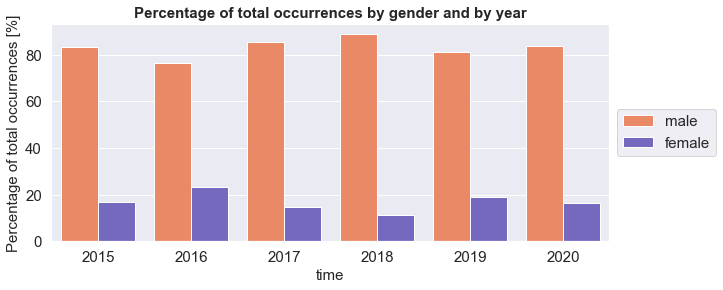

In [23]:
ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['Occurrences']*100,
                 hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years, 
                palette = {"male": "coral", "female": "slateblue"})
ax.set_ylabel('Percentage of total occurrences [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of total occurrences by gender and by year', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

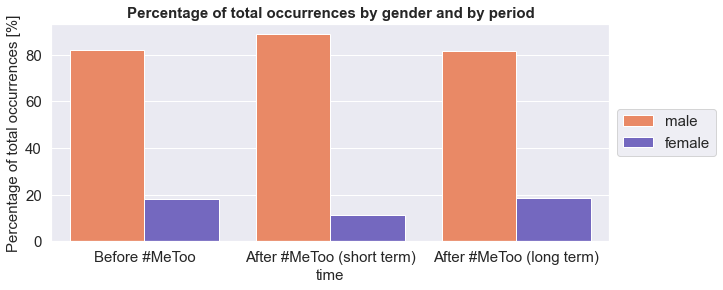

In [24]:
ax = sns.barplot(x = quotes_by_gender_periods['time'], 
                 y = quotes_by_gender_periods['Occurrences']*100, 
                 hue = quotes_by_gender_periods['gender'], data = quotes_by_gender_periods, 
                palette = {"male": "coral", "female": "slateblue"})
ax.set_ylabel('Percentage of total occurrences [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of total occurrences by gender and by period', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

We see that these graphs are essentially the same as the previous ones. Taking the number of unique quotations or the total number of occurrences by gender, we get the same proportions.

### Number of speakers by gender from 2015 to 2020

Previously, we examined the proportions of unique quotes by gender, as well as the proportion of total occurrences attributed to each gender. In this final section, let us examine the proportion of unique speakers of each gender over time.

In [25]:
by_speaker_years = []
for year, quotes in zip(years, quotes_years):
    by_speaker_years.append(unique_speaker_per_gender(quotes, year))

quotes_by_speaker_years = pd.concat(by_speaker_years, ignore_index = True)

In [26]:
quotes_by_speaker_years

,gender,count,time
0,male,0.789898,2015
1,female,0.210102,2015
2,male,0.782931,2016
3,female,0.217069,2016
4,male,0.777618,2017
5,female,0.222382,2017
6,male,0.786479,2018
7,female,0.213521,2018
8,male,0.778153,2019
9,female,0.221847,2019


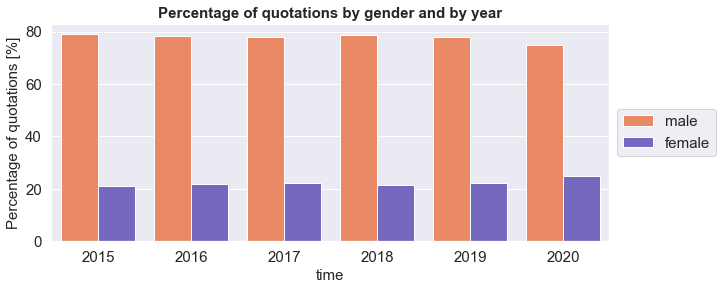

In [27]:
ax = sns.barplot(x = quotes_by_speaker_years['time'], y = quotes_by_speaker_years['count']*100,
                 hue = quotes_by_speaker_years['gender'], data = quotes_by_speaker_years, 
                palette = {"male": "coral", "female": "slateblue"})
ax.set_ylabel('Percentage of quotations [%]', fontsize = 15)
ax.set_xlabel('time', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of quotations by gender and by year', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

Again, we see that the proportion of male speakers is far greater than that of female speakers since they represent 80% of all speakers. However, in this graph, we observe a linear increase in female speakers over the years 2015 to 2020. In particular, in 2020, the proportion of female speakers reaches 20%. This is not the case when we look at the graph of occurences and quotations: it seems that a single male speaker has more quotations and occurences attributed to him than a female speaker.

In [28]:
by_speaker_periods = []
for period, quotes in zip(periods, quotes_years):
    by_speaker_periods.append(unique_speaker_per_gender(quotes, period))

quotes_by_speaker_periods = pd.concat(by_speaker_periods, ignore_index = True)

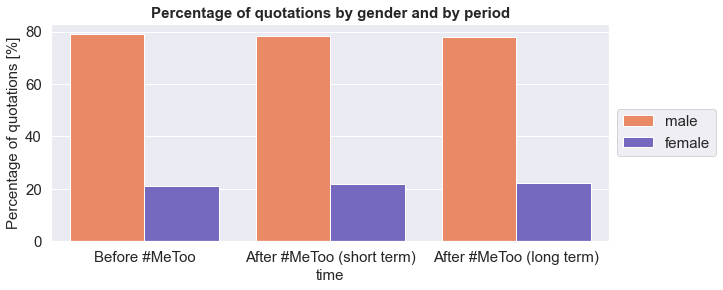

In [29]:
ax = sns.barplot(x = quotes_by_speaker_periods['time'], y = quotes_by_speaker_periods['count']*100, 
                 hue = quotes_by_speaker_periods['gender'], data = quotes_by_speaker_periods, 
                 palette = {"male": "coral", "female": "slateblue"})

ax.set_ylabel('Percentage of quotations [%]', fontsize=15)
ax.set_xlabel('time', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Percentage of quotations by gender and by period', fontweight="bold", fontsize=15);
ax.tick_params(labelsize=15)

Looking at this graph, we can see the same trend as above: there seem to be slightly more female speakers than male speakers over time. However, we don't know at this point if this is really related to the #MeToo movement or a general change in mindset.

### Lexical fields

Four different lexical fields are chosen and compared in the data. One is for "woman", another for "man" and the other two for "wife" and "husband". This study may give us a better understanding of the description and adjectives used to describe men and women in the newspapers.

In [30]:
chp_lex_woman = [' woman ', ' women ', ' girl ']
chp_lex_wife = [' wife ', ' girlfriend ']
chp_lex_man = [' man ', ' men ', ' boy ']
chp_lex_husband = [' husband ', ' boyfriend ']

Here a big dataframe is created gathering the data for all the years, with a new column "year", indicating the year.

The function $get\_champlex$ is applied for all years and the returned data frames are concatenated into a large data frame called "final_lexfield".

In [31]:
chplex2015 = get_champlex(quotes_all, int(2015), chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2016 = get_champlex(quotes_all, 2016, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2017 = get_champlex(quotes_all, 2017, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2018 = get_champlex(quotes_all, 2018, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2019 = get_champlex(quotes_all, 2019, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2020 = get_champlex(quotes_all, 2020, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)

final_lexfield = pd.concat([chplex2015,chplex2016,chplex2017,chplex2018,chplex2019,chplex2020],ignore_index = False)
final_lexfield.head(8)

,% of total quotations,% of total occurences,year
woman,1.204135,0.896357,2015.0
wife,0.085002,0.048856,2015.0
man,0.984414,0.786692,2015.0
husband,0.077945,0.056496,2015.0
woman,1.311841,1.117450,2016.0
wife,0.116153,0.083649,2016.0
man,1.217325,1.308662,2016.0
husband,0.086545,0.077371,2016.0


A barplot is presented showing the representation of each lexical field for each year.

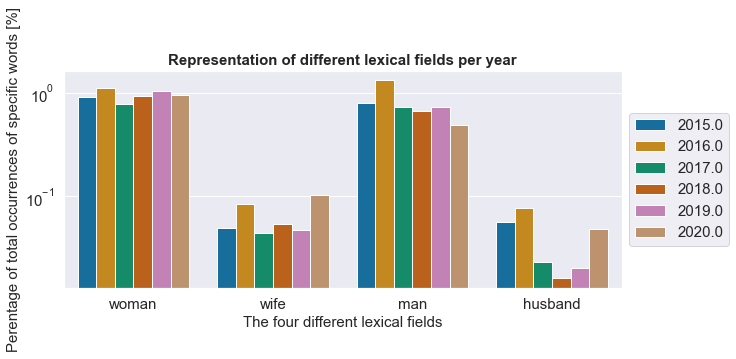

In [32]:
ax = sns.barplot(x =final_lexfield.index, y='% of total occurences',hue='year' ,data=final_lexfield)
plt.title('Representation of different lexical fields per year', fontsize = 15, fontweight = 'bold')
plt.xlabel('The four different lexical fields', fontsize = 15)
plt.ylabel('Perentage of total occurrences of specific words [%]', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set(yscale="log");
ax.tick_params(labelsize=15)

### Age of the speakers

In the next section, the average ages of the speaker quoted in the journals will be represented and described.

In [33]:
#Read the basic statistic of the age of our dataset
quotes_all.describe()

,numOccurrences,age,year
count,1.485071e+06,1.485071e+06,1.485071e+06
mean,6.638501e+00,6.350645e+01,2.017198e+03
std,3.682969e+01,1.211472e+01,1.504020e+00
min,1.000000e+00,1.500000e+01,2.015000e+03
25%,1.000000e+00,5.500000e+01,2.016000e+03
50%,1.000000e+00,6.500000e+01,2.017000e+03
75%,3.000000e+00,7.200000e+01,2.018000e+03
max,5.509000e+03,3.140000e+02,2.020000e+03


We observe some abnormalities in the wikidata ages: someone is -6 years old, and another one is 2016 years old. Thus, we decide to keep only speakers born in the 20th century. These are also more relevant to our study.

In [34]:
#Removing age outliers
quotes_age = quotes_all.drop((quotes_all.loc[(quotes_all.age>110) | (quotes_all.age<10)]).index, inplace=False)

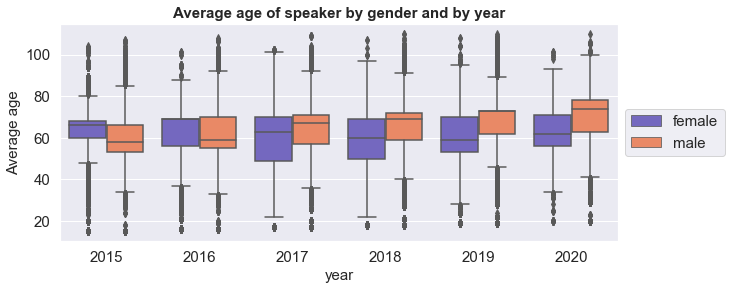

In [35]:
#Plot the distribution of age of the male and female speaker with respect to the year thanks to a boxlplot.
ax = sns.boxplot(x="year",y="age", hue="gender", 
                 data=quotes_age.loc[quotes_age['gender'].isin(['male','female'])], 
                palette = {"male": "coral", "female": "slateblue"});

ax.set_ylabel('Average age', fontsize = 15)
ax.set_xlabel('year', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Average age of speaker by gender and by year', fontsize = 15, fontweight = 'bold');
ax.tick_params(labelsize=15)

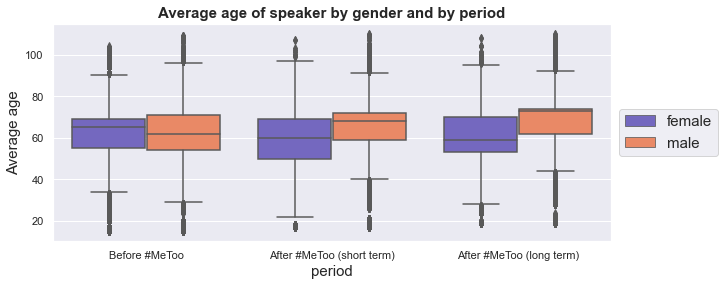

In [36]:
#For better vizualisation of the change that could have occured with the #MeToo movement, plot 
ax = sns.boxplot(x="period", y="age", hue="gender", 
                 data=quotes_age.loc[quotes_age['gender'].isin(['male','female'])], 
                 palette = {"male": "coral", "female": "slateblue"})

ax.set_ylabel('Average age', fontsize = 15)
ax.set_xlabel('period', fontsize = 15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title('Average age of speaker by gender and by period', fontsize = 15, fontweight = 'bold');

We do not observe any real significance between years or time periods regarding the age of the speakers. The average age in relation to gender is fairly constant over time. The difference is only between the age of female speakers and the age of male speakers. Indeed, women are always younger on average, and in the quartiles of a few years, than men. However, this is not a significant difference.

### Main occupations represented

The next analysis is to find out the occupations of the speakers in our dataset and understand the representation of male and female occupations.

In [37]:
#Compute the 20 most represented occupations, regardless of gender.
df_occupation = quotes_all.get(['occupation','gender']).explode(ignore_index=True, column='occupation')
most_represented_occupation = df_occupation.merge(pd.DataFrame(Counter(df_occupation.occupation)\
                          .most_common(20),columns =['occupation','nb_occurences']), how='right', on='occupation')
most_represented_occupation

,occupation,gender,nb_occurences
0,politician,female,1177493
1,politician,female,1177493
2,politician,female,1177493
3,politician,female,1177493
4,politician,female,1177493
...,...,...,...
6217184,real estate entrepreneur,male,214006
6217185,real estate entrepreneur,male,214006
6217186,real estate entrepreneur,male,214006
6217187,real estate entrepreneur,male,214006


Text(0.5, 0, 'occupation')

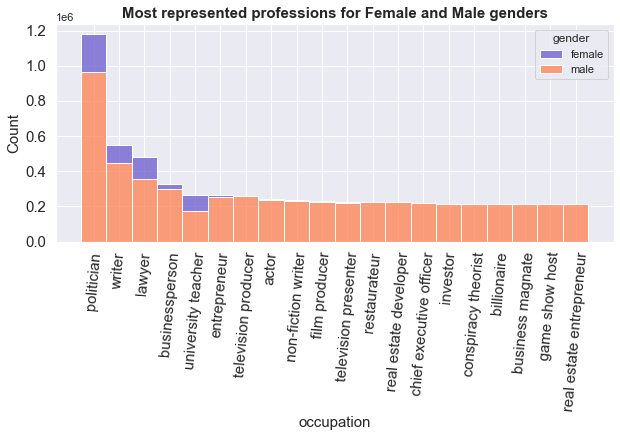

In [38]:
#Represent the 20 most represented occupations, distinguishing the share of men and women.
ax = sns.histplot(x="occupation", hue='gender', multiple="stack",
                 data=most_represented_occupation.loc[most_represented_occupation['gender'].isin(['male','female'])],
                 palette = {"male": "coral", "female": "slateblue"})
ax.set_title('Most represented professions for Female and Male genders', fontsize = 15, fontweight = 'bold')
ax.tick_params(labelsize=15)
plt.xticks(rotation=85);
plt.ylabel('Count', fontsize = 15)
plt.xlabel('occupation', fontsize = 15)

In [39]:
df_occ_female=quotes_all[quotes_all['gender']=='female'].occupation.explode(ignore_index=True)
df_occ_male=quotes_all[quotes_all['gender']=='male'].occupation.explode(ignore_index=True)
print('There are', df_occ_female.shape[0], 'occupations listed for women and', df_occ_male.shape[0], 
      'occupations listed for men. There are', math.floor(df_occ_male.shape[0]/df_occ_female.shape[0]), 
      'times more occupations for men than for women.')

There are 1139827 occupations listed for women and 8031392 occupations listed for men. There are 7 times more occupations for men than for women.


In [40]:
#Compute the 20 most reprensented occupations for female speakers
most_occ_female=pd.DataFrame(Counter(df_occ_female).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_female.head()

,occupation,nb_occurences
0,politician,215327
1,lawyer,121415
2,writer,104830
3,university teacher,91703
4,autobiographer,60224


In [41]:
#Compute the 20 most reprensented occupations for male speakers
most_occ_male=pd.DataFrame(Counter(df_occ_male).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_male.head()

,occupation,nb_occurences
0,politician,962166
1,writer,445514
2,lawyer,357169
3,businessperson,299410
4,television producer,259408


We next plot these informations below.

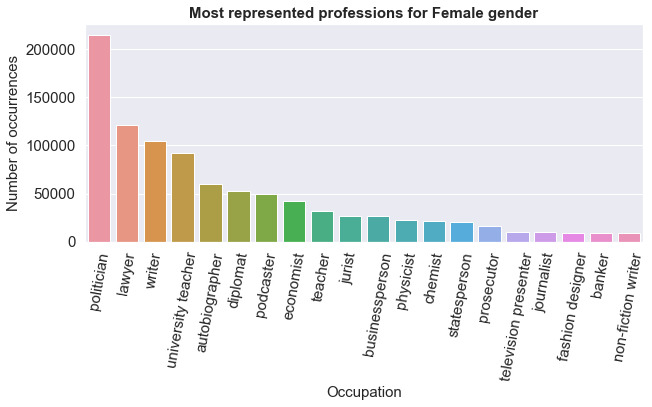

In [42]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_female)
ax.set_title('Most represented professions for Female gender', fontsize = 15, fontweight="bold")
ax.set_ylabel('Number of occurrences', fontsize = 15)
ax.set_xlabel('Occupation', fontsize = 15)
ax.tick_params(labelsize=15)
plt.xticks(rotation=80);

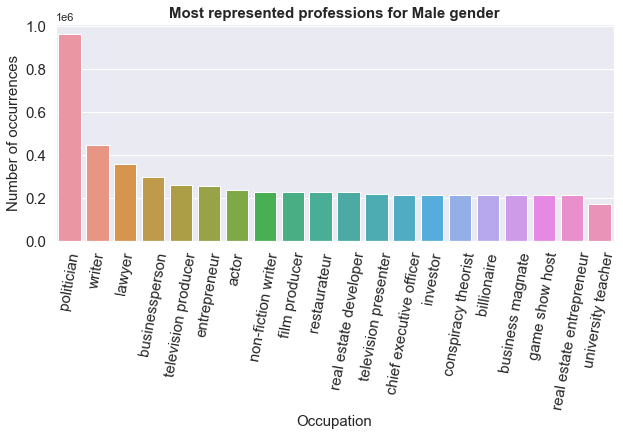

In [43]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_male)
ax.set_title('Most represented professions for Male gender', fontsize = 15, fontweight="bold")
ax.set_ylabel('Number of occurrences', fontsize = 15)
ax.set_xlabel('Occupation', fontsize = 15)
ax.tick_params(labelsize=15)
plt.xticks(rotation=80);

These barplots show us that the most represented occupation for both men and women is politician: 131133 occurrences for men and 30495 for women. Furthermore, the most cited occupations for male speakers are mainly in the sports categories (basketball, baseball, cricket, American soccer...), followed by business and arts. Women, on the other hand, are more present in the artistic professions (actor, television, writer, singer, composer...), then a little in the field of law and business.

### #MeToo breatdh in the news

Since our project focus on the #MeToo movement, we would like to take a look at the movement coverage in the news. We will compare the proportions of quotations per year in which words from the #MeToo lexical field appear. We choose to focus on the words "MeToo", "Weinstein", "sexual harrassment", and "sexual assault".

In [44]:
list_sexual_harassment = []
lex_sexual_harassment = ['sexual harassment', 'sexual assault', 'rape', 'sexual touching']
list_metoo = []
lex_metoo = ['MeToo', 'metoo', 'meToo', 'Metoo']
for year, quotes in zip(years, quotes_years):
    df_metoo = quotes[quotes['quotation'].str.contains('|'.join(lex_metoo))]
    df_sexual_harassment = quotes[quotes['quotation'].str.contains('|'.join(lex_sexual_harassment))]
    list_metoo.append([len(df_metoo)*100000/len(quotes),year])
    list_sexual_harassment.append([len(df_sexual_harassment)*100000/len(quotes),year])

In [45]:
quotes_sexual_harassment = pd.DataFrame(list_sexual_harassment, 
                                        columns = ['Nb of quotations about sexual harassment', 'year'])
quotes_metoo = pd.DataFrame(list_metoo, columns = ['Nb of quotations about #MeToo', 'year'])
quotes_metoo_harassment = quotes_sexual_harassment.merge(quotes_metoo)


In [46]:
quotes_metoo_harassment

,Nb of quotations about sexual harassment,year,Nb of quotations about #MeToo
0,150.877981,2015,0.000000
1,106.570924,2016,0.000000
2,160.506891,2017,1.941616
3,183.300254,2018,25.492088
4,149.080988,2019,8.015107
5,105.865831,2020,2.160527


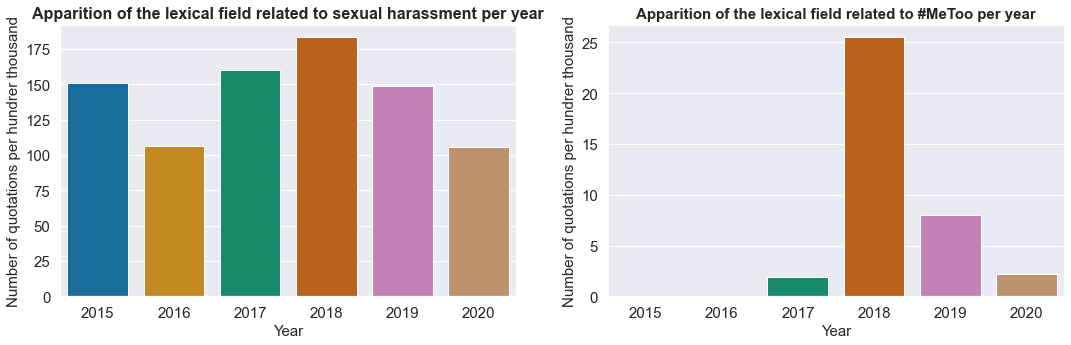

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

sns.barplot(ax= ax[0],x = quotes_metoo_harassment['year'], 
                 y = quotes_metoo_harassment['Nb of quotations about sexual harassment'], 
                 data = quotes_metoo_harassment);
ax[0].set_ylabel('Number of quotations per hundrer thousand', fontsize = 15)
ax[0].set_title('Apparition of the lexical field related to sexual harassment per year', 
                fontsize=16,fontweight="bold");
ax[0].set_xlabel('Year', fontsize = 15)
ax[0].tick_params(labelsize=15)

sns.barplot(ax= ax[1],x = quotes_metoo_harassment['year'], y = quotes_metoo_harassment['Nb of quotations about #MeToo'],
                 data = quotes_metoo_harassment);
ax[1].set_ylabel('Number of quotations per hundrer thousand', fontsize = 15)
ax[1].set_xlabel('Year', fontsize = 15)
ax[1].set_title('Apparition of the lexical field related to #MeToo per year', 
                fontsize=15,fontweight="bold");
ax[1].tick_params(labelsize=15)

We can see here that in 2015 and 2016, there were about 100 citations per 100000 talking about sexual harassment. It increased in 2017, the year of the #MeToo movement, and continued to increase until 2018 when we report 175 citations per 100000 talking about sexual harassment. However, after 2018, this number started to decrease and in 2020, we can see that we are back to 100 citations per 100000, as before the #MeToo movement.

As expected, there is no quotation about #MeToo before the movement in 2017. There is a rise at the time of the movement in 2017. However it represents only 40 quotations for 100000. We would have expected more, and it tells us that the coverage in the news was not as big as what we thought. The movement is still cited a few times per year, but not much.

## Observational study

### Data preparation

In [48]:
quotes = pd.read_json(QUOTES_DATA)

In this section, we prepare the dataset to analyze it. First, we will map every occupation to a more general category. We will do the same for the academic degree. 

In [49]:
print('The categories for occupations are:', list(set(dict_occupations.values())))
print('\n')
print('The categories for academic degree are:', list(set(dict_degrees.values())))


The categories for occupations are: ['Military & Order', 'Medical', 'Teaching & Education', 'Athlete', 'Law', 'Informatics', 'Social Sciences & Ethnology', 'Managing', 'Handicraft & Agriculture', 'Engineer', 'Literature', 'Entertainment', 'Administrative', 'Government', 'Artist', 'Music Industry', 'Scientist', 'Historian', 'Philosophy', 'Business', 'Religion', 'Activist', 'Psychology', 'Other', 'Service', 'Finance', 'Scholar', 'Media & Journalism']


The categories for academic degree are: ['certificate', 'not classified', 'candidate', 'bachelor', 'aggregation', 'doctor', 'professor', 'non specified degree', 'high school diploma', 'master']


In [50]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [51]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [52]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

For the further analyses, we distinguish two groups: 
- the speakers before #MeToo
- the speakers after #MeToo

The goal is to compare these two groups of speakers in terms of their number of quotes and their number of occurrences. To do so, we need to group the quotations by speaker and by label: indeed, if the same speaker appears before and after #MeToo, he will be counted in the group **before** with only the quotations he said before, and he will also be counted in the group **after** with only the quotations he said after.

In [53]:
grouped_speakers = quotes.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the `academic degree`, the `occupation`, the `speaker` name and the `gender`), thus we can recover it from the first quotation.

In [54]:
attributes_immutable = grouped_speakers.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)

Now we will calculate the number of quotes per speaker and the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [55]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_speakers['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_speakers['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_speakers['age'].median().reset_index(name='age')

In [56]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])

In [57]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])
data_per_speaker.sample(4)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age
7565,Q56604798,0,Franz Kraus,male,"[Managing, Engineer]",[professor],9,9,70.0
849,Q1323651,1,Karsten Danzmann,male,"[Teaching & Education, Scientist]",[doctor],26,40,63.0
8547,Q7363747,1,Ron Estes,male,"[Government, Handicraft & Agriculture, Business]","[bachelor, master]",397,717,62.0
6767,Q4768773,1,Dame Anne Salmond,female,"[Historian, Teaching & Education, Scientist]",[doctor],118,197,73.0


Our data are almost ready for the observational study. We will one-hot encode the categorical variables `occupation`,`academic_degree` and `gender`. This will be useful later for the logistic regression.

In [58]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)
dummies_gender = pd.get_dummies(data_per_speaker['gender'])

/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_63277/3217713273.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_63277/3217713273.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)


In [59]:
#Drop the columns 'Others'
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [60]:
#Rename columns with more readable names
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_occ.columns = dummies_occ.columns.str.replace("&", "and")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

Finally, we obtain a dataframe with unique combinaison (`qids`, `label`), and the attributes related to speakers during the given period (before or after #Metoo), with the categorical one being one hot encoded.

In [61]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)
data_features = pd.merge(data_features, dummies_gender, left_index = True, right_index = True)
data_features.sample(5)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
66,Q103884,1,Christoph M. Schmidt,male,"[Teaching & Education, Social Sciences & Ethno...","[bachelor, doctor, master]",8,31,56.0,0,...,0,0,1,0,1,0,0,0,0,1
6055,Q4287911,1,Dmitry Medoyev,male,[Government],[doctor],4,4,58.0,0,...,0,0,1,0,0,0,0,0,0,1
9140,Q93149,0,Madhu Sudan,male,"[Informatics, Teaching & Education]",[doctor],13,29,50.0,0,...,0,0,1,0,0,0,0,0,0,1
423,Q1173676,0,David Baulcombe,male,"[Teaching & Education, Medical, Scientist]",[doctor],3,8,65.0,0,...,0,0,1,0,0,0,0,0,0,1
9241,Q968616,1,Alexander Lowen,male,[Psychology],"[bachelor, doctor]",4,6,108.5,0,...,0,0,1,0,0,0,0,0,0,1


Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

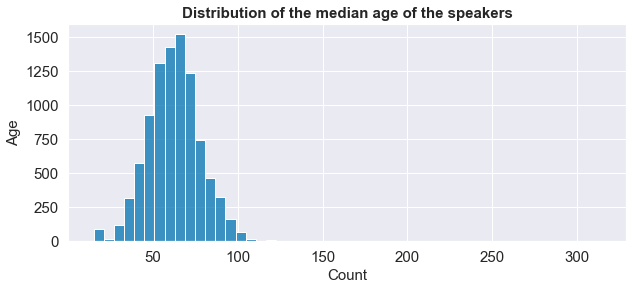

In [62]:
ax = sns.histplot(data_features['age'], bins = 50)
ax.set_title("Distribution of the median age of the speakers", fontsize = 15, fontweight = 'bold');
ax.set_ylabel("Age", fontsize = 15)
ax.set_xlabel("Count", fontsize = 15)
ax.tick_params(labelsize=15)

The age distribution seems to follow a Gaussian distribution, so we will normalize it. If we observe people with a high age, it is certainly because we sometimes quote people who lived a long time ago. We decided to keep them, since it still reveals whether we are quoting more men or women.

In [63]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate],1,2,-1.109912,0,...,1,0,0,0,0,0,0,0,0,1
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor],1,1,-0.198774,0,...,0,0,1,0,0,0,0,0,0,1


Now the dataset is ready!

### Create a balanced dataset

To answer the following questions:
- Do women speak more after the movement than before?
- Did the profile of female speakers change after the movement (in terms of occupations)?

We will conduct an observational study. The objective is to match "identical" female speakers from the control group (before #MeToo) and the treatment group (after #MeToo). To do this, we will calculate propensity scores (the probability that a speaker is a speaker after #MeToo given their observable covariates). This will be done using logistic regression. Then, we will associate the speakers whose propensity scores are closest. 

First, we know that some speakers might appear before and after the #MeToo movement. We decide to pair them up, because the goal is to match 2 identical person in terms of their observable covariates, but here, we already know that they are the same person! With just a few years more. But we assume that the difference in age in minor compared to the fact that all other covariates are exaclty the same, and not only the observable ones, since it is the same person!

Thus, we first pair the identical speakers that appear in both groups (control and treated). Then, for the others (i.e., speakers who speak ONLY before the movement or ONLY after), we will use the propensity score method based on the observable covariates `age`, `gender`, `occupation` and `academic_degree`.

#### Pair up identical speakers

In [64]:
print("Number of speakers speaking both before and after",
      data_features[data_features['qids'].duplicated(keep = 'first') == True].shape[0])

Number of speakers speaking both before and after 3363


In [65]:
data_features.drop(['academic_degree', 'occupation'], axis = 1, inplace = True)

In [66]:
speakers_twice = data_features[data_features['qids'].duplicated(keep = False) == True]

#### Pair up non-identical speakers

In [67]:
speakers_once = pd.concat([data_features,speakers_twice])

In [68]:
speakers_once.drop_duplicates(keep = False, inplace = True)

In [69]:
print('Now, we will try to pair up the other speakers, they are:', speakers_once.shape[0])

Now, we will try to pair up the other speakers, they are: 2622


##### Propensity score calculation

In this section, we calculate the propensity scores based on a logistic regression. 

In [70]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [71]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [72]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [73]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [74]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

Here, the goal of the logistic regression is to produce propensity scores as accurate as possible. The goal is not to train the regression on some training set in order to use it on other data: here we already have all the data we want to model. Thus, we will voluntarily try to overfit the data. To do so we use 2 methods:
- we set the regularization term to 0, because we don't want to penalize large weights
- we increase the number of iterations until it does not get better results: we avoid early stopping

In [75]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees + '+ C(female)', 
                data=speakers_once)

#Without regularization term 
res = mod.fit_regularized(maxiter = 10000000000000000, alpha = 0)

# Extract the estimated propensity scores
speakers_once['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6821128477363692
            Iterations: 245
            Function evaluations: 246
            Gradient evaluations: 245
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2622
Model:                          Logit   Df Residuals:                     2581
Method:                           MLE   Df Model:                           40
Date:                Wed, 15 Dec 2021   Pseudo R-squ.:                 0.01480
Time:                        11:02:35   Log-Likelihood:                -1788.5
converged:                       True   LL-Null:                       -1815.4
Covariance Type:            nonrobust   LLR p-value:                   0.07196
                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [76]:
speakers_once.head(3)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618
2,Q100308,1,Joachim Weimann,male,1,1,0.044196,0,0,0,...,0,1,0,0,0,0,0,0,1,0.459340


##### Matching by gender

In this section, we match the speakers with closest propensity scores. We match two speakers, only if they are of the same gender.

In [77]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [78]:
speakers_once.head(2)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618


In [79]:
"""# Separate the treatment and control groups
treatment_df = speakers_once[speakers_once['label'] == 1]
control_df = speakers_once[speakers_once['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)""";

In [80]:
"""matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_speakers_once = speakers_once.loc[matched]
balanced_speakers = pd.concat([balanced_speakers_once, speakers_twice])""";

In [81]:
"""##Pour éviter de run again le matching 
balanced_speakers.to_json(DATA_FOLDER + 'results/balanced_dataset_gender.json.bz2')""";

In [82]:
"""#On sauvegarde aussi les valeurs de paires
textfile = open("matching_by_gender.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()""";

We have saved the results of the matching in a separate file, which is called balanced_dataset_by_gender.json.bz2. The file is available [here](data/results/balanced_dataset_by_gender.json.bz2). We also save the pairs index in a file called matching_by_gender.txt, available [here](data/results/matching_by_gender.txt).

##### Matching by category of occupation

Now, we will try to analyze if some categories of occupations are more represented after the movement than before among women. Here again, we will compare with the evolution of men's speech. To do that, we will focus on the 8 main represented categories in the entire dataset.

In [83]:
main_categories = data_features[dummies_occ.columns.tolist()].sum().sort_values(ascending = False).head(8)
print('The 8 categories of occupations most represented in the dataset are:', main_categories.index.to_list())

The 8 categories of occupations most represented in the dataset are: ['Teaching_and_Education', 'Government', 'Scientist', 'Social_Sciences_and_Ethnology', 'Literature', 'Historian', 'Law', 'Media_and_Journalism']


Such as in the previous section, we will match pairs of speakers according to their propensity scores calculated above. We match exactly one speaker from the control group (speaker before #MeToo) with one speaker from the treated group (after #MeToo). We repeat the matching for each category, since we match only speakers of same gender and of same value for the category we want to analyze, i.e for example if we analyze the evolution of scientists' speech, we will pairs scientist women together, non-scientists women together, men scientists together and men non-scientists together.  

In [84]:
def match_by_category(df, category):
    # Separate the treatment and control groups
    treatment_df = df[df['label'] == 1]
    control_df = df[df['label'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            # Adds an edge only if the individuals have the same gender
            if (control_row['gender'] == treatment_row['gender'])  and (control_row[category] == 
                                                                        treatment_row[category]):
                similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    
    balanced_df = df.loc[matched,:]
    balanced_df.to_json(DATA_FOLDER + f'results/balanced_{category}.json.bz2')

In [85]:
#Cellule a decommenter le jour du rendu 
"""for category in main_categories.index:
    match_by_category(speakers_once, category)""";

We have saved the results of the matching in separate .json.bz2 files. They are available [here](data/results/balanced_{occupation}.json.bz2). 

## Results

### Comparison between men and women speakers in general

#### Take a look at the data

In [86]:
DATA_FOLDER_RESULT = 'data/results/'
BALANCED_DATA_BY_GENDER = DATA_FOLDER_RESULT + 'balanced_dataset_by_gender.json.bz2'

In [87]:
balanced_all_genders = pd.read_json(BALANCED_DATA_BY_GENDER)

Now that we have a balanced dataset, meaning we have pairs of similar speakers of same gender before and after the movement, let's quickly take a look at the size of our data.

In [88]:
pd.crosstab([balanced_all_genders.label], [balanced_all_genders.gender])

gender,female,male
label,,
0,983,3639
1,983,3639


Now, the goal is to compare the speakers' number of quotes and number of occurrences, depending on their gender, before and after #MeToo. Let's first take a look at the distributions of the data.

In [89]:
male_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'male']
fmale_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'female']

male_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&
                                         (balanced_all_genders['gender'] == 'male')]

male_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&
                                        (balanced_all_genders['gender'] == 'male')]

fmale_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&
                                          (balanced_all_genders['gender'] == 'female')]

fmale_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&
                                         (balanced_all_genders['gender'] == 'female')]

Here the distribution of the density of number of quotes per speaker, for both women and men after and before metoo, are plotted :

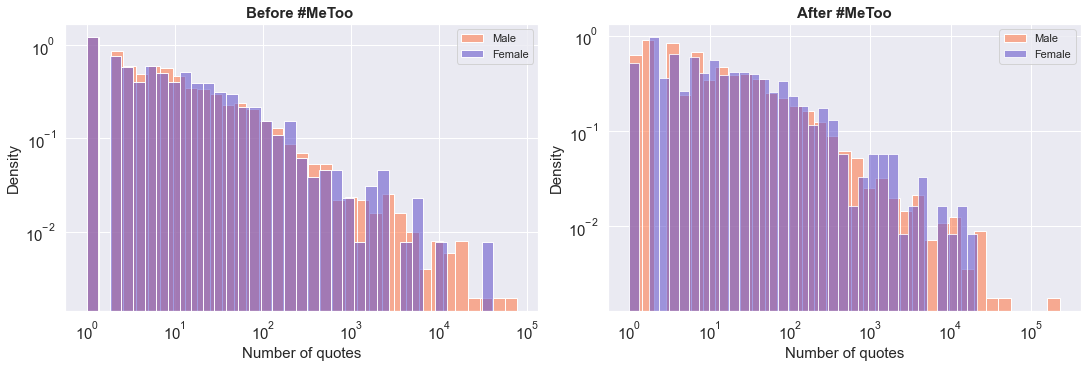

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True, figsize=(15, 5))
sns.histplot(ax = axs[0], 
                 data = male_before_metoo['nb_quotes'], 
                 bins = 35,
                 log_scale = True,
                 color = 'coral', 
                 alpha = 0.6, 
                 legend = True,
                 stat = 'density')
sns.histplot(ax = axs[0],
                 data = fmale_before_metoo['nb_quotes'], 
                 bins = 35,
                 log_scale = True,
                 color = 'slateblue', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
axs[0].set_title('Before #MeToo ', fontsize = 15, fontweight = 'bold')
axs[0].legend(labels=['Male','Female']);
axs[0].set(yscale = 'log')
axs[0].set_xlabel("Number of quotes", fontsize = 15)
axs[0].set_ylabel("Density", fontsize = 15)
axs[0].tick_params(labelsize=15)

sns.histplot(ax = axs[1],
                 data = male_after_metoo['nb_quotes'], 
                 bins = 35,
                 log_scale = True,
                 color = 'coral', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
sns.histplot(ax = axs[1],
                 data = fmale_after_metoo['nb_quotes'], 
                 bins = 35,
                 log_scale = True,
                 color = 'slateblue', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
axs[1].set_title('After #MeToo', fontsize = 15, fontweight = 'bold')
axs[1].legend(labels=['Male','Female']);
axs[1].set(yscale = 'log')
axs[1].set(yscale = 'log')
axs[1].set_xlabel("Number of quotes", fontsize = 15)
axs[1].set_ylabel("Density", fontsize = 15)
axs[1].tick_params(labelsize=15)

plt.show()

Here the distribution of the density of number of occurrences per speaker, for both women and men after and before metoo, are plotted :

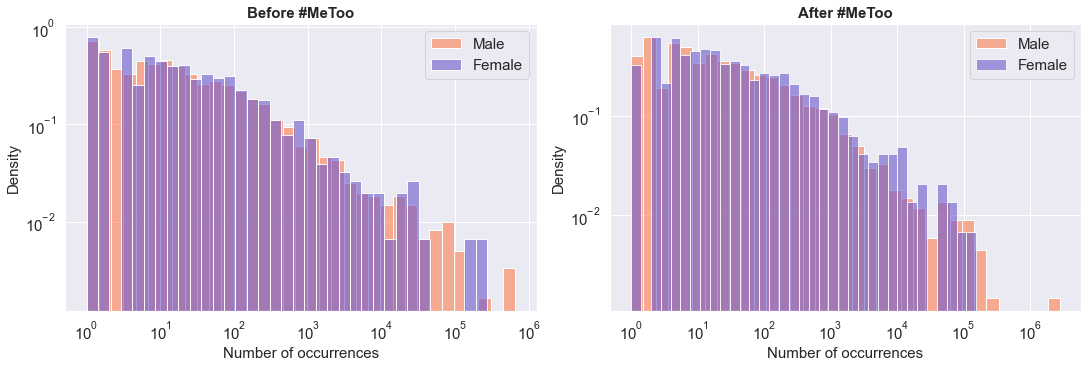

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True, figsize=(15, 5))
sns.histplot(ax = axs[0], 
                 data = male_before_metoo['nb_occurrences'], 
                 bins = 35,
                 log_scale = True,
                 color = 'coral', 
                 alpha = 0.6, 
                 legend = True,
                 stat = 'density')
sns.histplot(ax = axs[0],
                 data = fmale_before_metoo['nb_occurrences'], 
                 bins = 35,
                 log_scale = True,
                 color = 'slateblue', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
axs[0].set_title('Before #MeToo', fontsize = 15, fontweight = 'bold')
axs[0].legend(labels=['Male','Female'], fontsize = 15);
axs[0].set(yscale = 'log')
axs[0].set_xlabel("Number of occurrences", fontsize = 15);
axs[0].set_ylabel("Density", fontsize = 15);
axs[0].tick_params(labelsize=15)

sns.histplot(ax = axs[1],
                 data = male_after_metoo['nb_occurrences'], 
                 bins = 35,
                 log_scale = True,
                 color = 'coral', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
sns.histplot(ax = axs[1],
                 data = fmale_after_metoo['nb_occurrences'], 
                 bins = 35,
                 log_scale = True,
                 color = 'slateblue', 
                 alpha = 0.6, 
                 legend = True, 
                 stat = 'density')
axs[1].set_title('After #MeToo', fontsize = 15, fontweight = 'bold')
axs[1].legend(labels=['Male','Female'], fontsize = 15);
axs[1].set(yscale = 'log')
axs[1].set_xlabel("Number of occurrences", fontsize = 15);
axs[1].set_ylabel("Density", fontsize = 15);
axs[1].tick_params(labelsize=15)

We observe that the distributions are highly skewed. Thus, we will not use mean neither the standard deviation to compare our distributions. Instead, we will take a look at the median and the geometric means. We will create bootsraped confidence intervals for these estimators.

In [92]:
resume=[]
resume.append(["Female","Before #MeToo",
               fmale_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_occurrences'], dtype=None), 
               fmale_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_quotes'], dtype=None)
              ])

resume.append(["Male","Before #MeToo",
               male_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_occurrences'], dtype=None),
               male_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_quotes'], dtype=None)])

resume.append(["Female","After #MeToo", fmale_after_metoo['nb_occurrences'].median(),
               stats.mstats.gmean(fmale_after_metoo['nb_occurrences'], dtype=None), 
               fmale_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_after_metoo['nb_quotes'], dtype=None)])
              
resume.append(["Male","After #MeToo", male_after_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_occurrences'], dtype=None),
               male_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_quotes'], dtype=None)])


Res_mean_med_gmean=pd.DataFrame(resume)  
Res_mean_med_gmean.rename(columns={0: 'Gender', 1: 'Period', 
                                   2:"Median of Occurrences",3: 'Geometric Mean of Occurrences', 
                                   4: 'Median of nb quotes', 5: 'Geometric Mean of nb quotes'}, inplace=True)

Res_mean_med_gmean

,Gender,Period,Median of Occurrences,Geometric Mean of Occurrences,Median of nb quotes,Geometric Mean of nb quotes
0,Female,Before #MeToo,13.0,17.428753,7.0,9.301068
1,Male,Before #MeToo,11.0,15.829479,6.0,8.222666
2,Female,After #MeToo,19.0,29.190302,11.0,14.823034
3,Male,After #MeToo,15.0,21.651458,8.0,11.724268


The function `bootstrap_CI_med` boostraps our data nbr_draws time and compute each time the median of the data, returning in the end the confidence interval CI of the median of the data.

In [93]:
def bootstrap_CI_med(data, nbr_draws):
    medians = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        medians[n] = np.median(data_tmp)

    return [np.nanpercentile(medians, 2.5),np.nanpercentile(medians, 97.5)]

The function `bootstrap_CI_gm` boostraps our data nbr_draws time and compute each time the geometric mean of the data, returning in the end the confidence interval CI of the geometric mean of the data.

In [94]:
def bootstrap_CI_gm(data, nbr_draws):
    gm = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        gm[n] = stats.mstats.gmean(data_tmp,dtype=None)

    return [np.nanpercentile(gm, 2.5),np.nanpercentile(gm, 97.5)]

For the interactive plot, using plotly library, I had to plot the errors bars by hand by computing them using the boostrap_CI functions (for median and gemotric) : the `inf_val_med_fem_before_qu` and `sup_val_med_fem_before_qu` are for example the errorbar below and above `y`, here the median of the number of quotes.

In [95]:
med_fem_before_qu = fmale_before_metoo['nb_quotes'].median()
ci_med_fem_before_qu = bootstrap_CI_med(fmale_before_metoo['nb_quotes'],10000)
inf_val_med_fem_before_qu = med_fem_before_qu-ci_med_fem_before_qu[0]
sup_val_med_fem_before_qu = ci_med_fem_before_qu[1]-med_fem_before_qu

med_fem_after_qu = fmale_after_metoo['nb_quotes'].median()
ci_med_fem_after_qu = bootstrap_CI_med(fmale_after_metoo['nb_quotes'],10000)
inf_val_med_fem_after_qu = med_fem_after_qu-ci_med_fem_after_qu[0]
sup_val_med_fem_after_qu = ci_med_fem_after_qu[1]-med_fem_after_qu

med_mal_before_qu = male_before_metoo['nb_quotes'].median()
ci_med_mal_before_qu = bootstrap_CI_med(male_before_metoo['nb_quotes'],10000)
inf_val_med_mal_before_qu = med_mal_before_qu-ci_med_mal_before_qu[0]
sup_val_med_mal_before_qu = ci_med_mal_before_qu[1]-med_mal_before_qu

med_mal_after_qu = male_after_metoo['nb_quotes'].median()
ci_med_mal_after_qu = bootstrap_CI_med(male_after_metoo['nb_quotes'],10000)
inf_val_med_mal_after_qu = med_mal_after_qu-ci_med_mal_after_qu[0]
sup_val_med_mal_after_qu = ci_med_mal_after_qu[1]-med_mal_after_qu

Same for number of occurrences :

In [96]:
med_fem_before = fmale_before_metoo['nb_occurrences'].median()
ci_med_fem_before = bootstrap_CI_med(fmale_before_metoo['nb_occurrences'],10000)
inf_val_med_fem_before = med_fem_before-ci_med_fem_before[0]
sup_val_med_fem_before = ci_med_fem_before[1]-med_fem_before

med_fem_after = fmale_after_metoo['nb_occurrences'].median()
ci_med_fem_after = bootstrap_CI_med(fmale_after_metoo['nb_occurrences'],10000)
inf_val_med_fem_after = med_fem_after-ci_med_fem_after[0]
sup_val_med_fem_after = ci_med_fem_after[1]-med_fem_after

med_mal_before = male_before_metoo['nb_occurrences'].median()
ci_med_mal_before = bootstrap_CI_med(male_before_metoo['nb_occurrences'],10000)
inf_val_med_mal_before = med_mal_before-ci_med_mal_before[0]
sup_val_med_mal_before = ci_med_mal_before[1]-med_mal_before

med_mal_after = male_after_metoo['nb_occurrences'].median()
ci_med_mal_after = bootstrap_CI_med(male_after_metoo['nb_occurrences'],10000)
inf_val_med_mal_after = med_mal_after-ci_med_mal_after[0]
sup_val_med_mal_after = ci_med_mal_after[1]-med_mal_after

Same for geometric mean : 

In [97]:
gm_fem_before_qu = stats.mstats.gmean(fmale_before_metoo['nb_quotes'],dtype=None)
ci_gm_fem_before_qu = bootstrap_CI_gm(fmale_before_metoo['nb_quotes'],10000)
inf_val_gm_fem_before_qu = gm_fem_before_qu-ci_gm_fem_before_qu[0]
sup_val_gm_fem_before_qu = ci_gm_fem_before_qu[1]-gm_fem_before_qu

gm_fem_after_qu = stats.mstats.gmean(fmale_after_metoo['nb_quotes'],dtype=None)
ci_gm_fem_after_qu = bootstrap_CI_gm(fmale_after_metoo['nb_quotes'],10000)
inf_val_gm_fem_after_qu = gm_fem_after_qu-ci_gm_fem_after_qu[0]
sup_val_gm_fem_after_qu = ci_gm_fem_after_qu[1]-gm_fem_after_qu

gm_mal_before_qu = stats.mstats.gmean(male_before_metoo['nb_quotes'],dtype=None)
ci_gm_mal_before_qu = bootstrap_CI_gm(male_before_metoo['nb_quotes'],10000)
inf_val_gm_mal_before_qu = gm_mal_before_qu-ci_gm_mal_before_qu[0]
sup_val_gm_mal_before_qu = ci_gm_mal_before_qu[1]-gm_mal_before_qu

gm_mal_after_qu = stats.mstats.gmean(male_after_metoo['nb_quotes'],dtype=None)
ci_gm_mal_after_qu = bootstrap_CI_gm(male_after_metoo['nb_quotes'],10000)
inf_val_gm_mal_after_qu = gm_mal_after_qu-ci_gm_mal_after_qu[0]
sup_val_gm_mal_after_qu = ci_gm_mal_after_qu[1]-gm_mal_after_qu

In [98]:
gm_fem_before = stats.mstats.gmean(fmale_before_metoo['nb_occurrences'],dtype=None)
ci_gm_fem_before = bootstrap_CI_gm(fmale_before_metoo['nb_occurrences'],10000)
inf_val_gm_fem_before = gm_fem_before-ci_gm_fem_before[0]
sup_val_gm_fem_before = ci_gm_fem_before[1]-gm_fem_before

gm_fem_after = stats.mstats.gmean(fmale_after_metoo['nb_occurrences'],dtype=None)
ci_gm_fem_after = bootstrap_CI_gm(fmale_after_metoo['nb_occurrences'],10000)
inf_val_gm_fem_after = gm_fem_after-ci_gm_fem_after[0]
sup_val_gm_fem_after = ci_gm_fem_after[1]-gm_fem_after

gm_mal_before = stats.mstats.gmean(male_before_metoo['nb_occurrences'],dtype=None)
ci_gm_mal_before = bootstrap_CI_gm(male_before_metoo['nb_occurrences'],10000)
inf_val_gm_mal_before = gm_mal_before-ci_gm_mal_before[0]
sup_val_gm_mal_before = ci_gm_mal_before[1]-gm_mal_before

gm_mal_after = stats.mstats.gmean(male_after_metoo['nb_occurrences'],dtype=None)
ci_gm_mal_after = bootstrap_CI_gm(male_after_metoo['nb_occurrences'],10000)
inf_val_gm_mal_after = gm_mal_after-ci_gm_mal_after[0]
sup_val_gm_mal_after = ci_gm_mal_after[1]-gm_mal_after

Interactive figure of median of quotes and occurrences both gender before and after me too, with errorbars (computed above) :

In [99]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[med_mal_before_qu, med_mal_after_qu],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_mal_before_qu, sup_val_med_mal_after_qu],
                 arrayminus = [inf_val_med_mal_before_qu,inf_val_med_mal_after_qu]),marker_color="coral"
),row=1, col=1)
fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[med_fem_before_qu, med_fem_after_qu],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_fem_before_qu, sup_val_med_fem_after_qu],
                 arrayminus = [inf_val_med_fem_before_qu,inf_val_med_fem_after_qu]),marker_color="slateblue"
),row=1, col=1)
fig.update_layout(barmode='group')
fig.update_layout(title_text="Impact of Metoo movement on the median number of quotes for each gender ",
                  title_font_size=22)

fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[med_mal_before, med_mal_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_mal_before, sup_val_med_mal_after],
                 arrayminus = [inf_val_med_mal_before,inf_val_med_mal_after]),marker_color="coral",showlegend=False
),row=1, col=2)
fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[med_fem_before, med_fem_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_fem_before, sup_val_med_fem_after],
                 arrayminus = [inf_val_med_fem_before,inf_val_med_fem_after]),marker_color="slateblue",showlegend=False
),row=1, col=2)
fig.update_layout(barmode='group')
fig.update_layout(title_text="Impact of Metoo movement on the median number of quotes and occurrences for each gender ",
                  title_font_size=22)
fig.update_layout(height=500, showlegend=True)
fig.update_yaxes(title_text="median number of quotes", row=1, col=1)
fig.update_yaxes(title_text="median number of occurrences", row=1, col=2)
fig.show()

/Users/lisa/opt/anaconda3/envs/ada/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



Interactive figure of geometric mean of quotes and occurrences both gender before and after me too, with errorbars (computed above) :

In [100]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[gm_mal_before_qu, gm_mal_after_qu],
    error_y=dict(type='data',symmetric = False, array=[sup_val_gm_mal_before_qu, sup_val_gm_mal_after_qu],
                 arrayminus = [inf_val_gm_mal_before_qu,inf_val_gm_mal_after_qu]),marker_color="coral"
),row=1, col=1)
fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[gm_fem_before_qu, gm_fem_after_qu],
    error_y=dict(type='data',symmetric = False, array=[sup_val_gm_fem_before_qu, sup_val_gm_fem_after_qu],
                 arrayminus = [inf_val_gm_fem_before_qu,inf_val_gm_fem_after_qu]),marker_color="slateblue"
),row=1, col=1)

fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[gm_mal_before, gm_mal_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_gm_mal_before, sup_val_gm_mal_after],
                 arrayminus = [inf_val_gm_mal_before,inf_val_gm_mal_after]),marker_color="coral",showlegend=False
),row=1, col=2)

fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[gm_fem_before, gm_fem_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_gm_fem_before, sup_val_gm_fem_after],
                 arrayminus = [inf_val_gm_fem_before,inf_val_gm_fem_after]),marker_color="slateblue",showlegend=False
),row=1, col=2)

fig.update_layout(barmode='group')
fig.update_layout(title_text="Impact of Metoo movement on the geometric mean of number of occurrences for each gender ",
                  title_font_size=22)
fig.update_layout(height=500, showlegend=True)
fig.update_yaxes(title_text="geometric mean number of quotes", row=1, col=1)
fig.update_yaxes(title_text="geometric mean number of occurrences", row=1, col=2)
fig.show()

Static plots representing the median for number of occurrrences and number of quotes for both gender before and after metoo : 

In [101]:
balanced_plot = balanced_all_genders.copy()
balanced_plot['label'] = balanced_plot['label'].apply(lambda x: 'Before #MeToo' if x == 0 else 'After #MeToo')

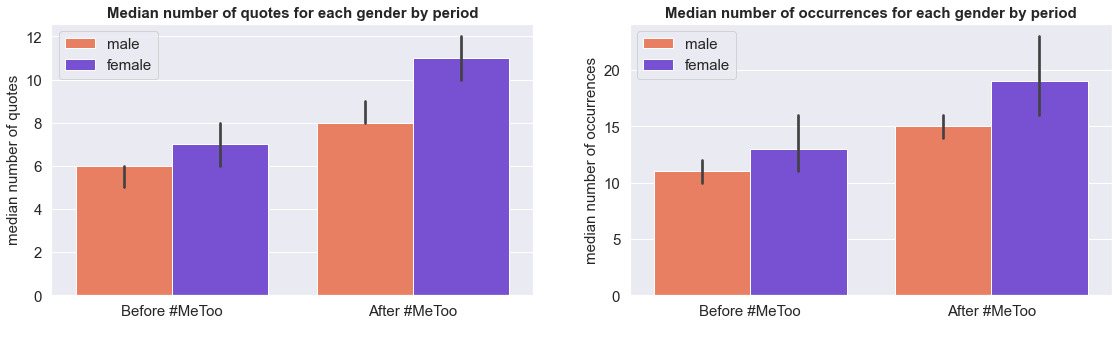

In [102]:
pal = {'female':'xkcd:bluish purple','male':'xkcd:pinkish orange'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(19,5))
sns.barplot(ax=ax[0],x="label", y="nb_quotes", data=balanced_plot,hue="gender",estimator=np.median,n_boot=10000,palette=pal)
sns.barplot(ax=ax[1],x="label", y="nb_occurrences", data=balanced_plot,hue="gender",estimator=np.median,n_boot=10000,palette=pal)
ax[0].set_ylabel('median number of quotes',fontsize=15)
ax[0].set_xlabel(" ")
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)
ax[0].set_title('Median number of quotes for each gender by period', 
                fontsize=15,fontweight="bold");
ax[0].tick_params(labelsize=15)
ax[0].legend(fontsize = 15)

ax[1].set_ylabel('median number of occurrences',fontsize=15)
ax[1].set_xlabel(" ")
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)
ax[1].set_title('Median number of occurrences for each gender by period', 
                fontsize=15,fontweight="bold");
ax[1].tick_params(labelsize=15)
ax[1].legend(fontsize = 15)

Static plots representing the geometric mean for number of occurrrences and number of quotes for both gender before and after metoo : 

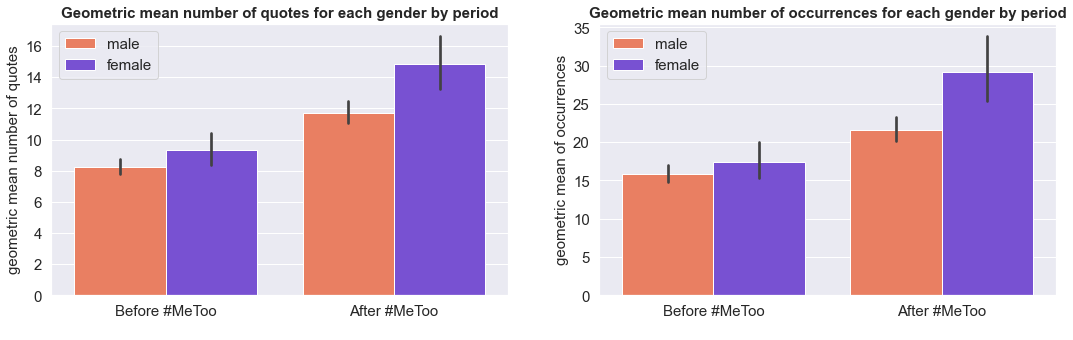

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
sns.barplot(ax=ax[0],x="label", y="nb_quotes", data=balanced_plot,hue="gender",estimator=stats.mstats.gmean,n_boot=10000,palette=pal)
sns.barplot(ax=ax[1],x="label", y="nb_occurrences", data=balanced_plot,hue="gender",estimator=stats.mstats.gmean,n_boot=10000,palette=pal)
ax[0].set_ylabel('geometric mean number of quotes',fontsize=15)
ax[0].set_xlabel(" ")
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)
ax[0].set_title('Geometric mean number of quotes for each gender by period', 
                fontsize=15,fontweight="bold");
ax[0].tick_params(labelsize=15)
ax[0].legend(fontsize = 15)

ax[1].set_ylabel('geometric mean of occurrences',fontsize=15)
ax[1].set_xlabel(" ")
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)
ax[1].set_title('Geometric mean number of occurrences for each gender by period', 
                fontsize=15,fontweight="bold");
ax[1].tick_params(labelsize=15)
ax[1].legend(fontsize = 15)

First, we observe that before #MeToo, women speakers have a median number of quotes and of occurrences higher than men. The geometric means show the same results. This results means even if much more men speak in the news, when a women speak, she has a higher number of quotes and of occurrences attributed to herself. After the movement, the median number of quotes and occurrences of speakers has increased for both male and female speakers. However, we observe a bigger increase for female speakers with a median number of quotes per speaker of 7 before the movement compared to 11 after. The male speakers had also seen their median number of quotes per speaker increased from 6 before to 8 after: the increase is 2 times bigger for the female speakers. Similar results are observed for the number of occurrences per speaker, and the geometric means confirms the findings.

#### Statistical tests by gender 
In order to see if these differences are significant, we will perform some statistical tests. In this context, since our data are not normally distributed, we need to use a non-parametric statistical hypothesis test. We will use the Wilcoxon signed-rank test. The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences is symmetric about zero. In this case, we will perform this test two times: once for female and once for male speakers. In both cases, the null hypothesis is that the median of the population differences (between before and after #MeToo) is zero. The alternative hypothesis is that it is not.

In [104]:
male_diff_occ = pingouin.wilcoxon(male_after_metoo['nb_occurrences'], male_before_metoo['nb_occurrences'])
male_diff_occ['gender'] = 'male'
female_diff_occ = pingouin.wilcoxon(fmale_after_metoo['nb_occurrences'], fmale_before_metoo['nb_occurrences'])
female_diff_occ['gender'] = 'female'

pd.concat([male_diff_occ,female_diff_occ]).set_index('gender')

,W-val,alternative,p-val,RBC,CLES
gender,,,,,
male,2314602.0,two-sided,8.905204e-32,0.229978,0.542622
female,138984.5,two-sided,2.898956e-22,0.366114,0.565810


In [105]:
male_diff_quotes = pingouin.wilcoxon(male_after_metoo['nb_quotes'], male_before_metoo['nb_quotes'])
male_diff_quotes['gender'] = 'male'
female_diff_quotes = pingouin.wilcoxon(fmale_after_metoo['nb_quotes'], fmale_before_metoo['nb_quotes'])
female_diff_quotes['gender'] = 'female'

pd.concat([male_diff_quotes,female_diff_quotes]).set_index('gender')

,W-val,alternative,p-val,RBC,CLES
gender,,,,,
male,1718747.0,two-sided,3.253897e-82,0.383534,0.561005
female,108310.0,two-sided,1.482200e-36,0.481962,0.575163


Here, we calculated the W-value, the p-value but also two different measures of the effect size:
- matched pairs rank-biserial correlation (RBC): difference between the proportion of favorable and unfavorable evidence. Letting f be the proportion of pairs favorable to the hypothesis, and letting u be the proportion of pairs not favorable, the rank-biserial r is the simple difference between the two proportions: r = f − u
- common language effect size (CLES): proportion of pairs where the number of quotes or occurrences is higher for the speaker after #MeToo than for the speaker before #MeToo.

**Conclusion:** We observe very small p-values in each case, meaning that there is a significant difference in median of the number of quotes and of the number of occurrences before and after the movement, for both genders. The positive rank-biserial correlation (RBC) indicates that those speaking after the movement are quoted more frequently than speakers before the movement. Looking at the common language effect size (CLES), we can affirm that for any pairing of speakers before and after the movement, the probability of the speaker after to have more quotes than the speaker before is 0.56 for males and 0.57 for females. The probability of the speaker after to have more occurrences is 0.54 for males and 0.56 for females. Even if the p-values indicate significant results, the effect sizes are small (CLES < 0.6). 

Thus, we conclude that in general speakers after #MeToo speak more than speakers before #MeToo. However, even if this phenomenon seems to be a little bit more pronounced for women, we osberve the same trend for both gender, with small effect sizes. We think that our analysis might be too general, so we decide to focus on certain occupations for the rest of the analysis. We will analyze if the profile of the female speakers has changed: whether the professions represented have differed post-Metoo, and once again we will compare this evolution with male speakers.

#### A first look at the occupations...

In this section, we will get a taste of what are the main categories of occupations represented in the news among women and men speakers.

We will now look at the occupations of the male and female speaker : The idea is to create a wordcloud figure to show the representation (in terms of frequency) of occupations in our dataset `balanced_all_genders` for each gender before and after Metoo.

In [106]:
#converts my list into a dict, useful for generation of worldcloud : 
def Convert(lst):
    res_dct = {lst[i][0]: lst[i][0+1] for i in range(0, len(lst))}
    return res_dct

The function `create_Worldcloud` is implemented and takes as arguments a dataset `df` and a path to the  the image we want to give the final wordcloud, `mask_image`.

In [107]:
def create_Worldcloud(df,mask_image):
    font_path = 'data/true_south/True South.ttf'
    tupl = [tuple(x) for x in df.values]
    dict_ready = Convert(tupl)
    mask_ = np.array(Image.open(mask_image))
    df_wordcloud = wordcloud.WordCloud(font_path = font_path,width = 500,max_font_size = 300,height=500 ,
                                       background_color="white",relative_scaling = 0.4, max_words=500,
                                       mask=mask_,contour_width=3, 
                                       contour_color='peru').generate_from_frequencies(dict_ready)
    return df_wordcloud

`get_occup` function is implemented to get back the column `occupation` for the dataset `balanced_all_genders`

In [108]:
def get_occup (rowss,columns_occ) : 
    list_occ = columns_occ.columns.to_list()
    rowss['occupation']= []
    for i in range(0,len(list_occ)) : 
        if (rowss[list_occ[i]] == 1) :
            rowss['occupation'].append(list_occ[i])
    return (rowss)

In [109]:
balanced_all_genders= balanced_all_genders.apply(lambda row : get_occup(row,dummies_occ),axis=1)

In [110]:
data_features = data_features.apply(lambda row : get_occup(row,dummies_occ),axis=1)

Creation of dataframe for women and men before and after Metoo : 

In [111]:
df_occ_female_before=balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender']=='female')].occupation.explode(ignore_index=True)
df_occ_female_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_male_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)
df_occ_male_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)

In [112]:
df_occ_female_before= data_features[(data_features['label']==0)&(data_features['gender']=='female')].occupation.explode(ignore_index=True)
df_occ_female_after = data_features[(data_features['label']==1)&(data_features['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_male_before = data_features[(data_features['label']==0)&(data_features['gender'] == 'male')].occupation.explode(ignore_index=True)
df_occ_male_after = data_features[(data_features['label']==1)&(data_features['gender'] == 'male')].occupation.explode(ignore_index=True)

Here, the occupations for the female and male before and after me too are sorted in non-ascending order (from the most common to least common) creating four dataframes, `most_occ_female_before` , `most_occ_female_after`, `most_occ_male_before` and `most_occ_male_after`.

In [113]:
#Compute the reprensented occupations for female speakers before me too
most_occ_female_before=pd.DataFrame(Counter(df_occ_female_before).most_common(),
                                    columns =['occupation', 'nb_occurences'])
print('for women before metoo : ')
print(most_occ_female_before.head())

most_occ_male_before = pd.DataFrame(Counter(df_occ_male_before).most_common(),
                                    columns =['occupation', 'nb_occurences'])
most_occ_male_before.dropna(inplace=True)
print('for men before metoo : ')
print(most_occ_male_before.head())

#Compute the reprensented occupations for female speakers after me too
most_occ_female_after=pd.DataFrame(Counter(df_occ_female_after).most_common(),
                                   columns =['occupation', 'nb_occurences'])
print('for women after metoo : ')
print(most_occ_female_after.head())

most_occ_male_after=pd.DataFrame(Counter(df_occ_male_after).most_common(),
                                 columns =['occupation', 'nb_occurences'])

most_occ_male_after.dropna(inplace=True)
print('for men after metoo : ')
print(most_occ_male_after.head())

for women before metoo : 
                      occupation  nb_occurences
0         Teaching_and_Education            332
1                     Government            257
2                      Scientist            234
3                     Literature            193
4  Social_Sciences_and_Ethnology            141
for men before metoo : 
                      occupation  nb_occurences
0         Teaching_and_Education           1439
1                     Government           1004
2                      Scientist            908
3  Social_Sciences_and_Ethnology            777
4                     Literature            677
for women after metoo : 
                      occupation  nb_occurences
0         Teaching_and_Education            321
1                     Government            269
2                      Scientist            247
3                     Literature            182
4  Social_Sciences_and_Ethnology            142
for men after metoo : 
                      occupation  nb_o

The most represented occupations are quite similar for the men and women and before and after metoo. However, the men are more represented than women for almost every occupation, because there are more men in our dataset (men are speaking more than women in newspapers ).

Some occupation name are replaced by smaller names in order to have a clearer wordcloud.

In [114]:
for c in [most_occ_female_before, most_occ_female_after, most_occ_male_before, most_occ_male_after]:
    
    c['occupation'].replace({'Teaching_and_Education':'Teaching',
                            'Social_Sciences_and_Ethnology': 'Social_sciences',
                            'Media_and_Journalism':'Media'},inplace=True)
    

The four different wordcloud are generated using the function created above : 

In [115]:
#before me too
Worldcloud_before_fem = create_Worldcloud(most_occ_female_before, 'data/female.png')
Worldcloud_before_mal = create_Worldcloud(most_occ_male_before,'data/male.png')

#after me too
Worldcloud_after_fem = create_Worldcloud(most_occ_female_after,'data/female.png')
Worldcloud_after_mal = create_Worldcloud(most_occ_male_after,'data/male.png')

The wordcloud are plotted : 

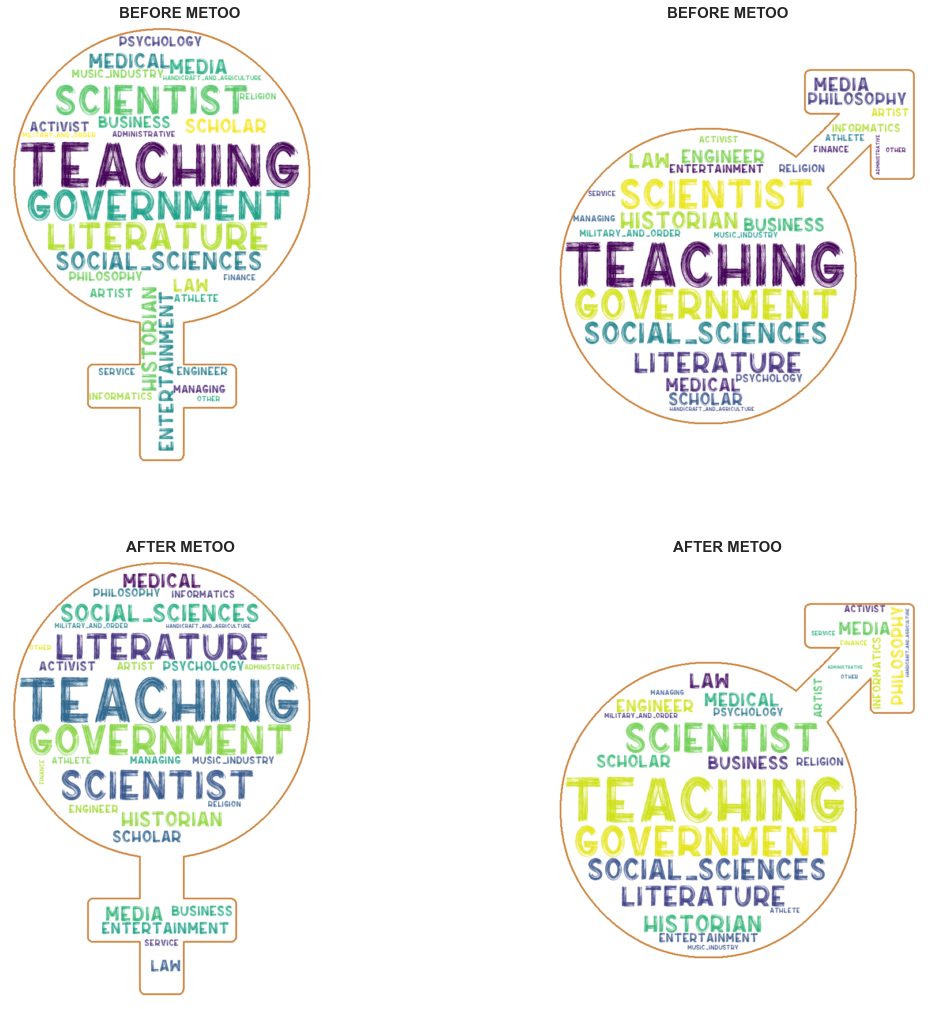

In [116]:
fig,ax = plt.subplots(2,2, figsize=(18,18))
ax[0,0].imshow(Worldcloud_before_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('BEFORE METOO',fontsize=15,fontweight="bold")
ax[0,1].imshow(Worldcloud_before_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,1].set_title('BEFORE METOO',fontsize=15,fontweight="bold")
ax[0,1].axis("off")
ax[1,0].imshow(Worldcloud_after_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,0].set_title('AFTER METOO',fontsize=15,fontweight="bold")
ax[1,0].axis("off")
ax[1,1].imshow(Worldcloud_after_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,1].set_title('AFTER METOO',fontsize=15,fontweight="bold")
ax[1,1].axis("off")
plt.show()

Now, we decided to study some specific categories that are represented a lot such as Teaching, or some than seem quite interesting to compare before and after me too for men and women, such as law or media. 

### Comparison between men and women speakers by category of occupation

Following our matching process, we create one dataset per balanced occupation

In [117]:
balanced_teaching = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Teaching_and_Education.json.bz2'), 
                               speakers_twice])

balanced_government = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Government.json.bz2'), 
                               speakers_twice])

balanced_scientist = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Scientist.json.bz2'), 
                               speakers_twice])

balanced_social_sciences=pd.concat([pd.read_json(DATA_FOLDER+'results/balanced_Social_Sciences_and_Ethnology.json.bz2'), 
                               speakers_twice])

balanced_literature = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Literature.json.bz2'), 
                               speakers_twice])

balanced_historian = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Historian.json.bz2'), 
                               speakers_twice])

balanced_law = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Law.json.bz2'), 
                               speakers_twice])

balanced_media = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Media_and_Journalism.json.bz2'), 
                               speakers_twice])


In [118]:
cat=[balanced_teaching, balanced_government, balanced_scientist, balanced_social_sciences,balanced_literature,
    balanced_historian, balanced_law, balanced_media]

cat_names=["Teaching_and_Education", "Government", "Scientist", "Social_Sciences_and_Ethnology","Literature",
           "Historian", "Law", "Media_and_Journalism"]

cat_non_names=["Non_Teaching_and_Education", "Non_Government", "Non_Scientist", "Non_Social_Sciences_and_Ethnology",
               "Non_Literature", "Non_Historian", "Non_Law", "Non_Media_and_Journalism"]


For each occupation, we show the geometric mean of the number of quotes depending on:
- The gender
- The occupation status of the speaker for the specified occupation
    - 0: The speaker doesn't work in this occupation field
    - 1: The speaker works in this occupation field
- The label:
    - 0: Before #MeToo
    - 1: After #MeToo

In [119]:
def tablegmeans(c,name):
    print(("\033[1m" + "Occupation: " + name + "\033[0m").center(100))
    print('\n')
    print(pd.crosstab(c.label, [c.gender, c[name]]))
    print('\n')
    gmean_occupations(c, name, 'nb_quotes')

In [120]:
"""k=0
for c in cat:
    tablegmeans(c,cat_names[k])
    print("\n")
    k+=1""";

In [121]:
#Function to build a dataFrame for a specific balanced_occupation, classify speakers between occupation and non_occupation
def create_dF_category(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    no=c[(c[name] == 0)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfNo=pd.DataFrame(no)
    dfNo['Occupation'] = non_name
    Full=pd.concat([dfYes,dfNo])
    return Full    

In [122]:
#Creation of one dataFrame for each occupation
fulls=[]
j=0
for n in range(8):
    full=create_dF_category(cat[j],cat_names[j],cat_non_names[j])
    full['label'].replace({0:"Before #MeToo",1:"After #MeToo"},inplace=True)
    fulls.append(full)
    j+=1


In [123]:
#Function to build a dataFrame for each balanced_occupation with only the speakers who performed this occupation
def create_dF_yes(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    return dfYes


In [124]:
#Creation of one dataframe per occupation with only the positive occupation concatenation of all the dataframes
yey=[]
j=0
for n in range(8):
    e=create_dF_yes(cat[j],cat_names[j],cat_non_names[j])
    e.drop([cat_names[j]], axis = 1, inplace = True)
    yey.append(e)
    j+=1
ye=pd.concat(yey)


In [125]:
ye.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

ye['label'].replace({0:"Before #MeToo",1:"After #MeToo"},inplace=True)

In [126]:
#data frame that repertoriates for each gender, period and occupation the proportion of the number of quotes
#fpr this occupation among others
i=0
l=[]
for f in fulls:    
    a=f[(f['gender'] == "female")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    b=f[(f['gender'] == "female")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    
    l.append(["Female",a/(a+b),"Before #MeToo",cat_names[i]])

    c=f[(f['gender'] == "female")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()
    d=f[(f['gender'] == "female")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()

    l.append(["Female",c/(c+d),"After #MeToo",cat_names[i]])

    a=f[(f['gender'] == "male")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    b=f[(f['gender'] == "male")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "Before #MeToo")].nb_quotes.sum()
    
    l.append(["Male",a/(a+b),"Before #MeToo",cat_names[i]])

    c=f[(f['gender'] == "male")&(f['Occupation'] == cat_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()
    d=f[(f['gender'] == "male")&(f['Occupation'] == cat_non_names[i])&
               (f['label'] == "After #MeToo")].nb_quotes.sum()

    l.append(["Male",c/(c+d),"After #MeToo",cat_names[i]])



    i+=1
prop=pd.DataFrame(l)

prop.rename(columns={0: 'Gender', 1: 'Proportion', 
                                   2:"Label",3: 'Occupation'},inplace=True)

prop.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

#### Proportion number of quotes of a specific occupations among others

In [127]:
"""fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'Proportion', hue = 'Label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = prop[(prop['Gender'] == "Female")]);

ax[0].set_ylabel('Proportion',fontsize=14)
ax[0].set_xlabel("Occupation",fontsize=14)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[0].set_title('Proportion of the number of quotes for each occupation \n among others for Female', 
                fontsize=18,fontweight="bold");


sns.barplot(ax=ax[1],x = 'Occupation', y = 'Proportion', hue = 'Label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = prop[(prop['Gender'] == "Male")]);

ax[1].set_ylabel('Proportion',fontsize=14)
ax[1].set_xlabel("Occupation",fontsize=14)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
ax[1].set_title('Proportion of the number of quotes for each occupation \n among others for Male', 
                fontsize=18,fontweight="bold");""";


For female speakers, we observe a smaller proportion of occupation-speakers among occupation+non_occupation speakers after #MeToo than Before except for Social Sciences.
For male speakers, we observe a smaller proportion of occupation-speakers among occupation+non_occupation speakers after #MeToo than Before for Teaching, Scientist, Historian, Law and media.


#### Overview of the occupation categories

We will give a look at the geometric mean and at the median for the different occupation categories before and after #Metoo for each gender for:
- The number of quotations
- The number of occurences

In [128]:
i=0
F=[]
M=[]
for c in cat:
    F.append([cat_names[i],
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_quotes'])/
              stats.gmean(c[(c['label'] == 0) & (c['female'] == 1)& (c[cat_names[i]] == 1)]['nb_quotes']),
              
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_occurrences'])/
              stats.gmean(c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_occurrences']),
              
                 np.median(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_quotes'])/
              np.median(c[(c['label'] == 0) & (c['female'] == 1)& (c[cat_names[i]] == 1)]['nb_quotes']),
              
                 np.median(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_occurrences'])/
              np.median(c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 1)]['nb_occurrences']),
                
                "1/0","Female"])
    
    M.append([cat_names[i],
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes'])/
              stats.gmean(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes']),
              
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences'])/
              stats.gmean(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences']),
              
                 np.median(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes'])/
              np.median(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_quotes']),
              
                 np.median(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences'])/
              np.median(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 1)]['nb_occurrences']),
                 
                 "1/0","Male"])

    i+=1

In [129]:
i=0
Fn=[]
Mn=[]
for c in cat:
    Fn.append([cat_non_names[i],
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_quotes'])/
               stats.gmean(c[(c['label'] == 0) & (c['female'] == 1)& (c[cat_names[i]] == 0)]['nb_quotes']),
               
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_occurrences'])/
               stats.gmean(c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_occurrences']),
               
                 np.median(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_quotes'])/
               np.median(c[(c['label'] == 0) & (c['female'] == 1)& (c[cat_names[i]] == 0)]['nb_quotes']),
               
                 np.median(c[(c['label'] == 1) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_occurrences'])/
               np.median(c[(c['label'] == 0) & (c['female'] == 1) & (c[cat_names[i]] == 0)]['nb_occurrences']), 
               
                "1/0","Female"])
    
    Mn.append([cat_non_names[i],
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_quotes'])/
               stats.gmean(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_quotes']),
               
                 stats.gmean(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_occurrences'])/
               stats.gmean(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_occurrences']),
               
                 np.median(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_quotes'])/
               np.median(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_quotes']),
               
                 np.median(c[(c['label'] == 1) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_occurrences'])/
               np.median(c[(c['label'] == 0) & (c['female'] == 0)& (c[cat_names[i]] == 0)]['nb_occurrences']),
               
                 "1/0","Male"])

    i+=1

In [130]:
tot=pd.DataFrame(F+Fn+M+Mn)
tot.rename(columns={0: 'Occupation', 1: 'gmean Quotes', 2: 'gmean Occurences',
                    3: 'median Quotes', 4: 'median Occurences',5:"Label",6: 'Gender'}, inplace=True)
tot.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)
tot.head()

,Occupation,gmean Quotes,gmean Occurences,median Quotes,median Occurences,Label,Gender
0,Teaching,1.382637,1.422272,1.166667,1.272727,1/0,Female
1,Government,1.904107,2.012472,1.454545,1.833333,1/0,Female
2,Scientist,1.352479,1.586540,1.222222,1.514286,1/0,Female
3,Social_Sciences,1.762559,1.630198,1.833333,1.583333,1/0,Female
4,Literature,1.613595,1.727930,1.437500,1.576923,1/0,Female


##### Geometric mean of the number of quotations  for all occupations before and after #MeToo for each gender.
We plot the geometric mean of the number of quotations for each occupation before and after the #MeToo movement and for each gender

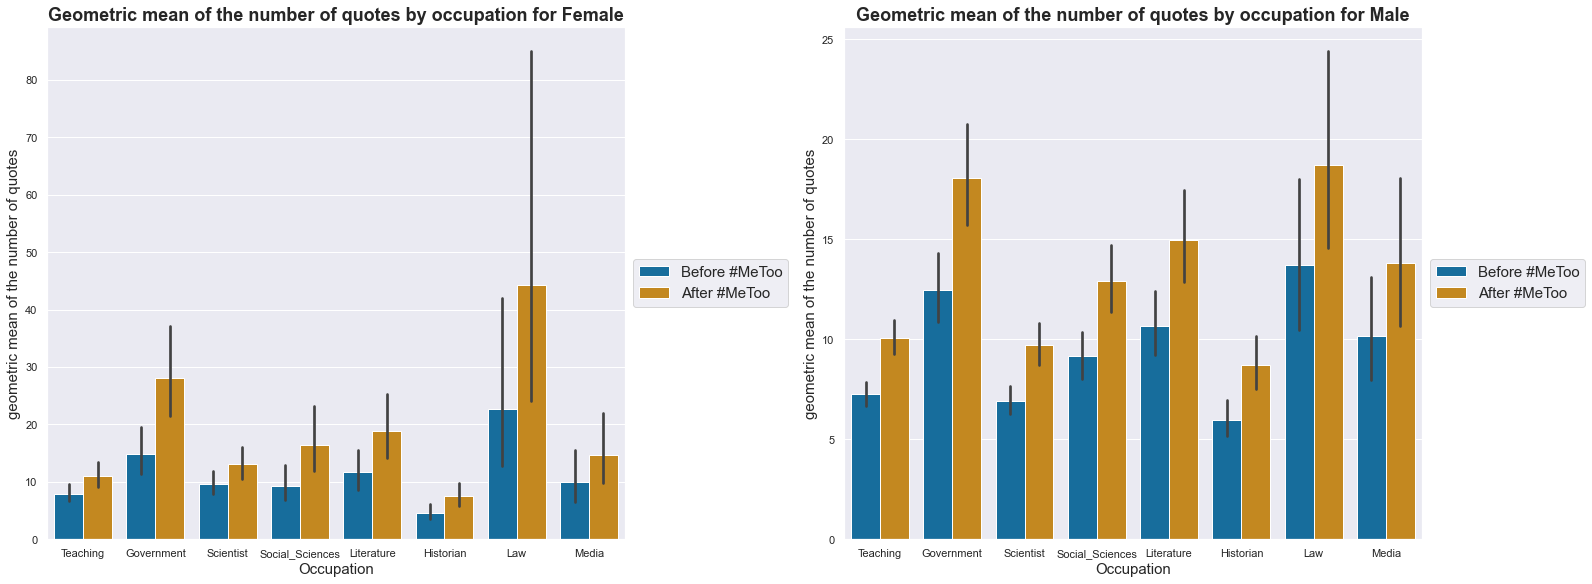

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);

ax[0].set_ylabel('geometric mean of the number of quotes',fontsize=15)
ax[0].set_xlabel("Occupation",fontsize=15)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[0].set_title('Geometric mean of the number of quotes by occupation for Female', fontsize=18,fontweight="bold");
#ax[0].tick_params(rotation = 75, labelsize=15)

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);

ax[1].set_ylabel('geometric mean of the number of quotes',fontsize=15)
ax[1].set_xlabel("Occupation",fontsize=15)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[1].set_title('Geometric mean of the number of quotes by occupation for Male', fontsize=18,fontweight="bold");
#ax[1].tick_params(rotation = 75, labelsize=15)


##### Geometric mean of the number of occurences of quotation  for all occupations before and after #MeToo for each gender.
We plot the geometric mean of the number of occurences for each occupation before and after the #MeToo movement and for each gender

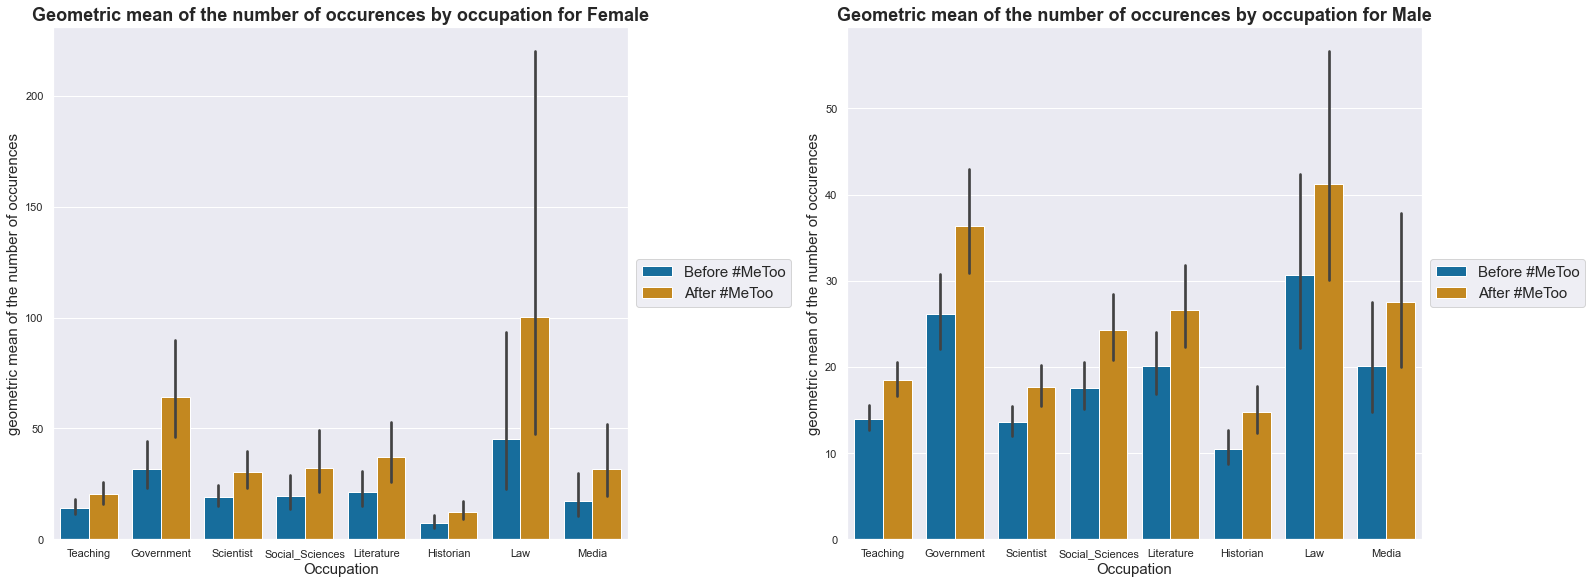

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);

ax[0].set_ylabel('geometric mean of the number of occurences',fontsize=15)
ax[0].set_xlabel("Occupation",fontsize=15)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[0].set_title('Geometric mean of the number of occurences by occupation for Female',fontsize=18,fontweight="bold");


sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);

ax[1].set_ylabel('geometric mean of the number of occurences',fontsize=15)
ax[1].set_xlabel("Occupation",fontsize=15)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[1].set_title('Geometric mean of the number of occurences by occupation for Male',fontsize=18,fontweight="bold");


##### Median of the number of quotations  for all occupations before and after #MeToo for each gender.
We plot the median of the number of quotations for each occupation before and after the #MeToo movement and for each gender

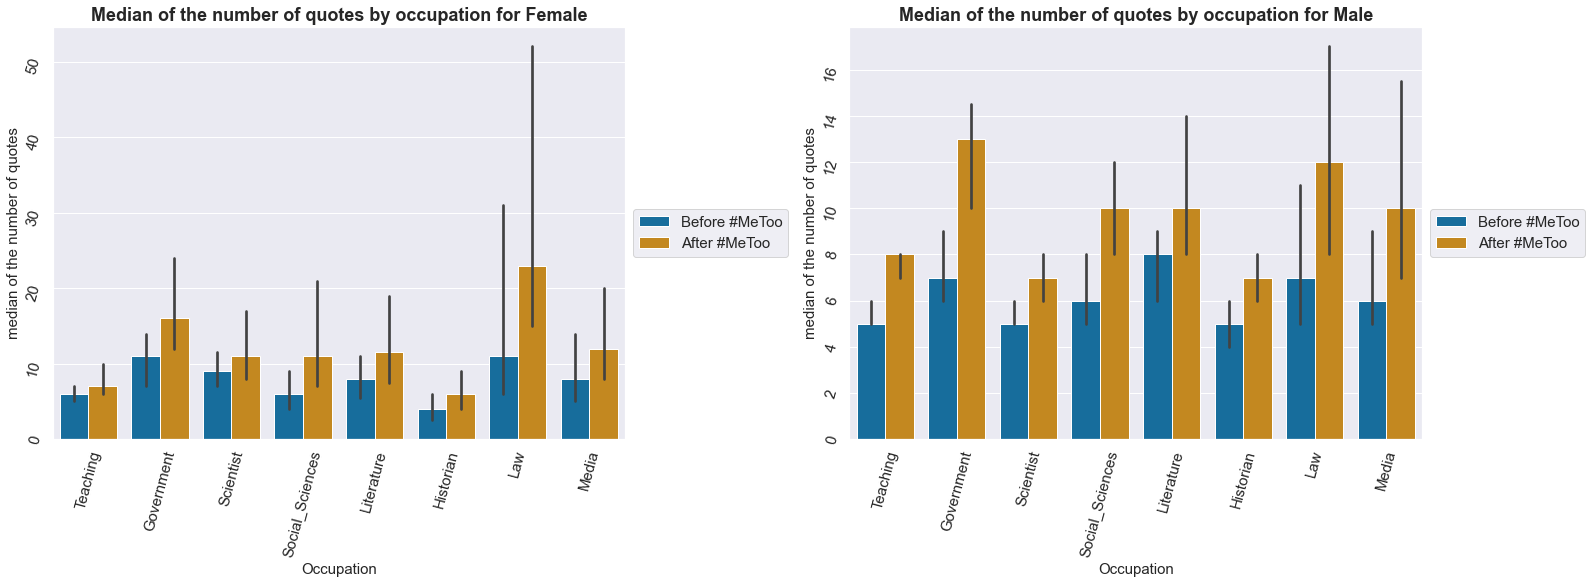

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set_ylabel('median of the number of quotes',fontsize=15)
ax[0].set_xlabel("Occupation",fontsize=15)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[0].set_title('Median of the number of quotes by occupation for Female',fontsize=18,fontweight="bold");
ax[0].tick_params(rotation = 75, labelsize=15)

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);

ax[1].set_ylabel('median of the number of quotes',fontsize=15)
ax[1].set_xlabel("Occupation",fontsize=15)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[1].set_title('Median of the number of quotes by occupation for Male',fontsize=18,fontweight="bold");
ax[1].tick_params(rotation = 75, labelsize=15)

##### Median of the number of occurences  for all occupations before and after #MeToo for each gender.
We plot the median of the number of occurences for each occupation before and after the #MeToo movement and for each gender

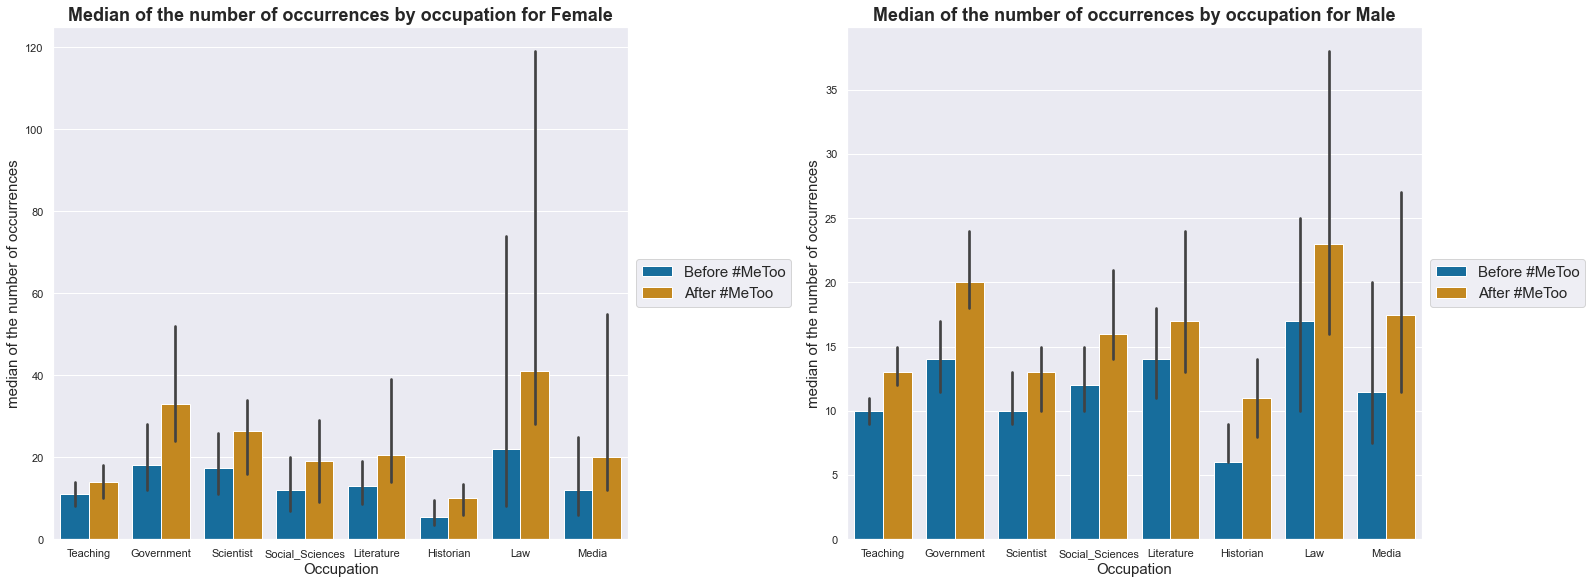

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set_ylabel('median of the number of occurrences',fontsize=15)
ax[0].set_xlabel("Occupation",fontsize=15)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[0].set_title('Median of the number of occurrences by occupation for Female',fontsize=18,fontweight="bold");
#ax[0].tick_params(labelsize=15)

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);

ax[1].set_ylabel('median of the number of occurrences',fontsize=15)
ax[1].set_xlabel("Occupation",fontsize=15)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
ax[1].set_title('Median of the number of occurrences by occupation for Male',fontsize=18,fontweight="bold");
#ax[1].tick_params(labelsize=15)


We observe the geometric mean and median for both number of quotations and number of occurences for each occupation category, for each gender before and after #MeToo movement. 
We observe similar results than when we overlooked at the female and male speakers in general with no consideration of the occupation category.
We observe higher geometric mean and median for both number of quotations and number of occurences for every occcupation category and for both genders after #MeToo than before #MeToo. 
Comparing men and women, we observe in general higher values for both geometric mean and median for both number of quotations and of occurences for women than for men. We however observe several exceptions:
- Higher Geometric Mean of number of quotations for men (before and after #Metoo) for the category: Historian
- Higher Geometric Mean of number of occurences for men (before and after #Metoo) for the category: Historian
- Higher Geometric Mean of number of occurences for men (before #Metoo) for the category: Media
- Higher Median of number of quotations for men (after #Metoo) for the category: Teaching and Government
- Higher Median of number of quotations for men (before and after #Metoo) for the category: Historian
- Higher Median of number of occurences for men (before and after #Metoo) for the category: Historian

The conclusions are the same than for the general female and male speakers: Even if there are more male than female speakers in the newspapers, a single female speaker will show a higher number of quotations and of occurences than a male speaker.

After the assesment that the number of quotations and of occurences have indeed increased after #MeToo for both genders, we would like to compare the evolution of the two genders. We observe in most of cases a higher ratio After/Before for female than for male except for the following cases: 
- Teaching: Median and Geometric mean of number of quotes 
- Government: Median of number of quotes
- Scientist: Median and Geometric mean of number of quotes 
- Media: Median of number of quotes

Further [statistical analysis](#Statistical-tests-by-both-occupation-and-gender) will help assessing the results shown in the graphs. It is important to note that the error bars have really large ranges for the law category for which the paired dataset is small. Next, we will analyze all categories except Law since it is not interpretable.




In [165]:
ye = ye[ye['Occupation'] != 'Law']

Let's plot again, but without the category "Law".

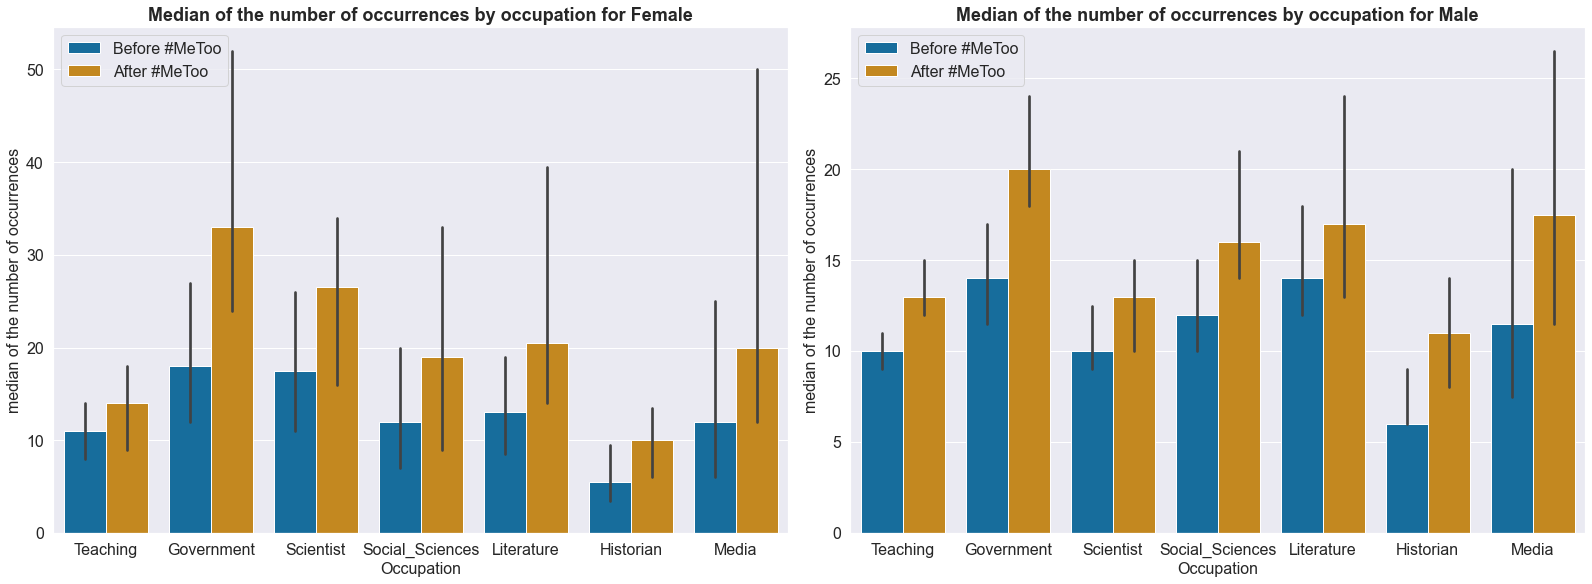

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(22, 8)) 

sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set_ylabel('median of the number of occurrences', fontsize=16)
ax[0].set_xlabel("Occupation", fontsize=16)

ax[0].set_title('Median of the number of occurrences by occupation for Female',fontsize=18,fontweight="bold");
ax[0].tick_params(labelsize=16)
ax[0].legend(fontsize = 16);

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label',
            hue_order = ['Before #MeToo', 'After #MeToo'],
            data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);

ax[1].set_ylabel('median of the number of occurrences', fontsize=16)
ax[1].set_xlabel("Occupation", fontsize=16)

ax[1].set_title('Median of the number of occurrences by occupation for Male',fontsize=18,fontweight="bold");
ax[1].tick_params(labelsize=16)
ax[1].legend(fontsize = 16);


#### Geometric mean of the number of quotations per occupation and per gender

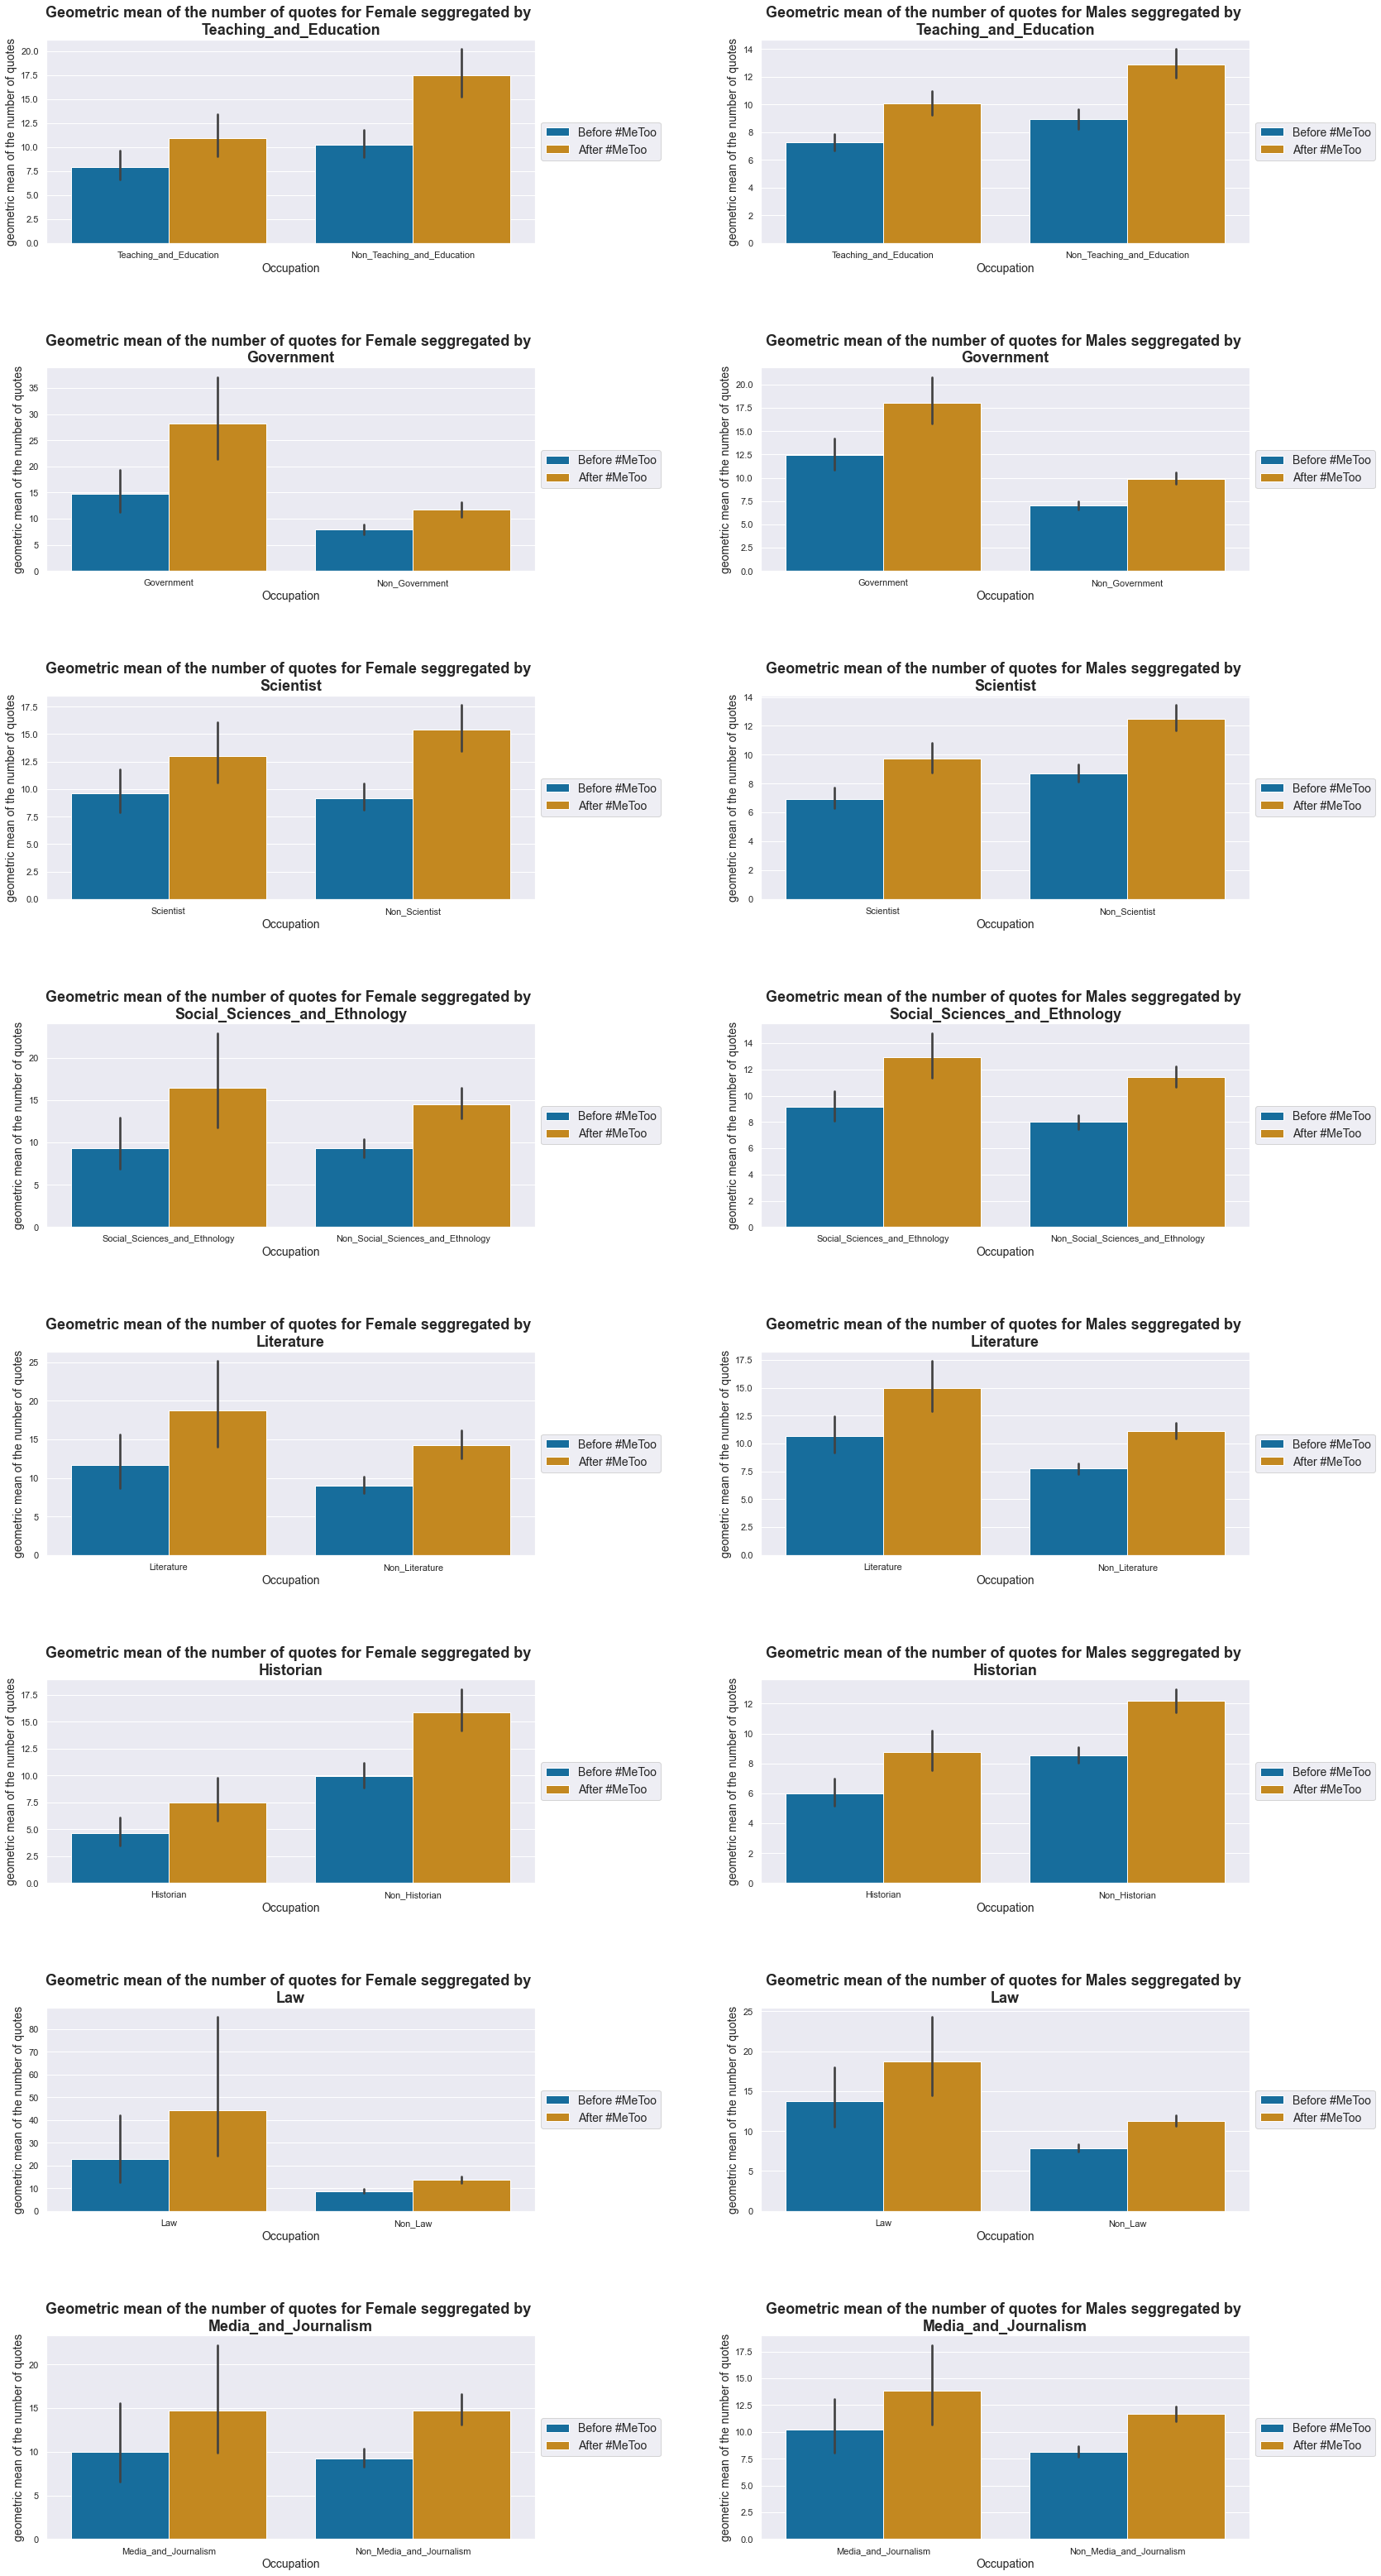

In [135]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0
for f in fulls:
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('geometric mean of the number of quotes',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Geometric mean of the number of quotes for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('geometric mean of the number of quotes',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Geometric mean of the number of quotes for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    i+=1

#### Median of the number of quotations per occupation and per gender

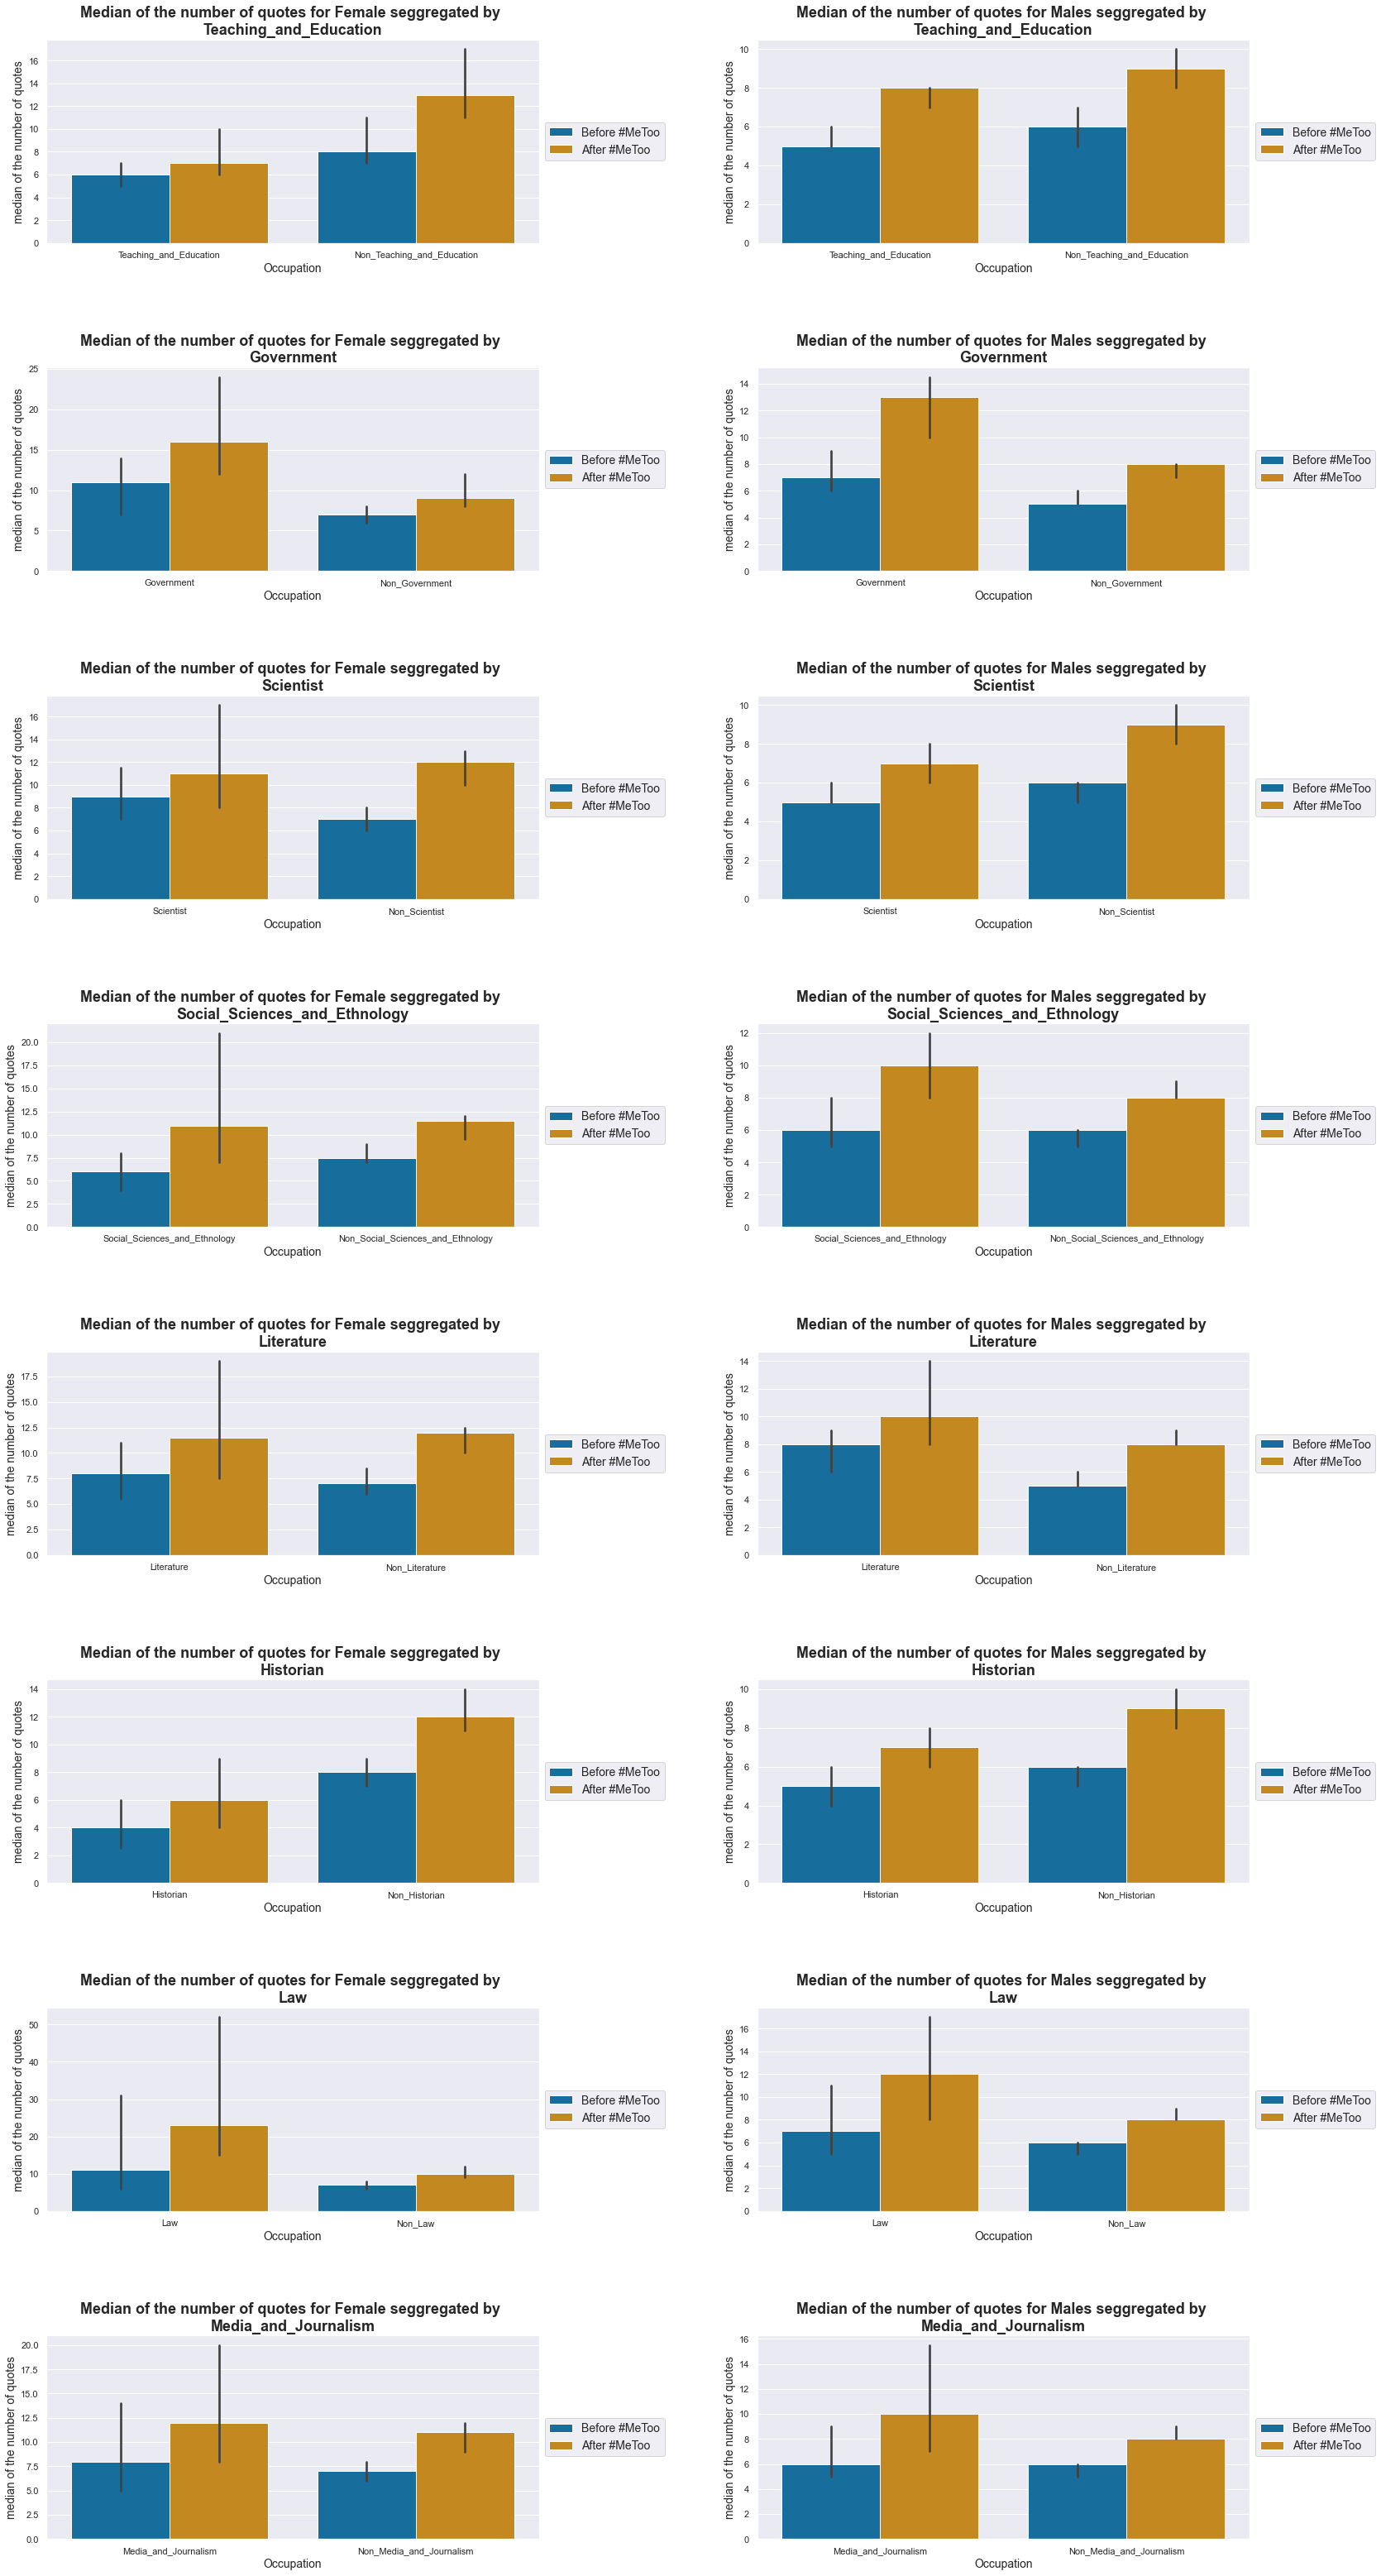

In [136]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0

for f in fulls:
    
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=np.median,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=np.median,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('median of the number of quotes',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Median of the number of quotes for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('median of the number of quotes',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Median of the number of quotes for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");
    i+=1


We observe higher geometric means and medians of number of quotations for every occupation for both genders after #MeToo. However, we would like to observe if this increase also happens in the speakers that are not in this occupation category. 
We observe a higher increase After/Before #MeToo for the non-occupation speakers compared to occupation speakers in the cases:

- Female:
    - Teaching (Both geometric mean and median of the number of quotes)
    - Scientist (Both geometric mean and median of the number of quotes)
    - Media (Both geometric mean and median of the number of quotes)
    
- Male:    
    - Teaching (median of the number of quotes)
    - Scientist (Both geometric mean and median of the number of quotes)
    - Social Sciences (Both geometric mean and median of the number of quotes)
    - Literature (Both geometric mean and median of the number of quotes)
    - Media (geometric mean of the number of quotes)
    - Law (geometric mean of the number of quotes)

This could give us a clue to tell that there is an increase of the representation of women in several occupations after #MeToo

In [137]:
fulls[1]

,nb_quotes,nb_occurrences,label,gender,Government,Occupation
4803,2,4,Before #MeToo,male,1,Government
1348,6,21,After #MeToo,male,1,Government
1633,3,43,Before #MeToo,male,1,Government
9337,1,1,After #MeToo,male,1,Government
1858,1,1,After #MeToo,female,1,Government
...,...,...,...,...,...,...
9335,56,56,After #MeToo,male,0,Non_Government
9342,56,87,Before #MeToo,female,0,Non_Government
9343,82,119,After #MeToo,female,0,Non_Government
9345,71,178,Before #MeToo,male,0,Non_Government


#### Geometric mean of the number of quotations per occupation and per gender

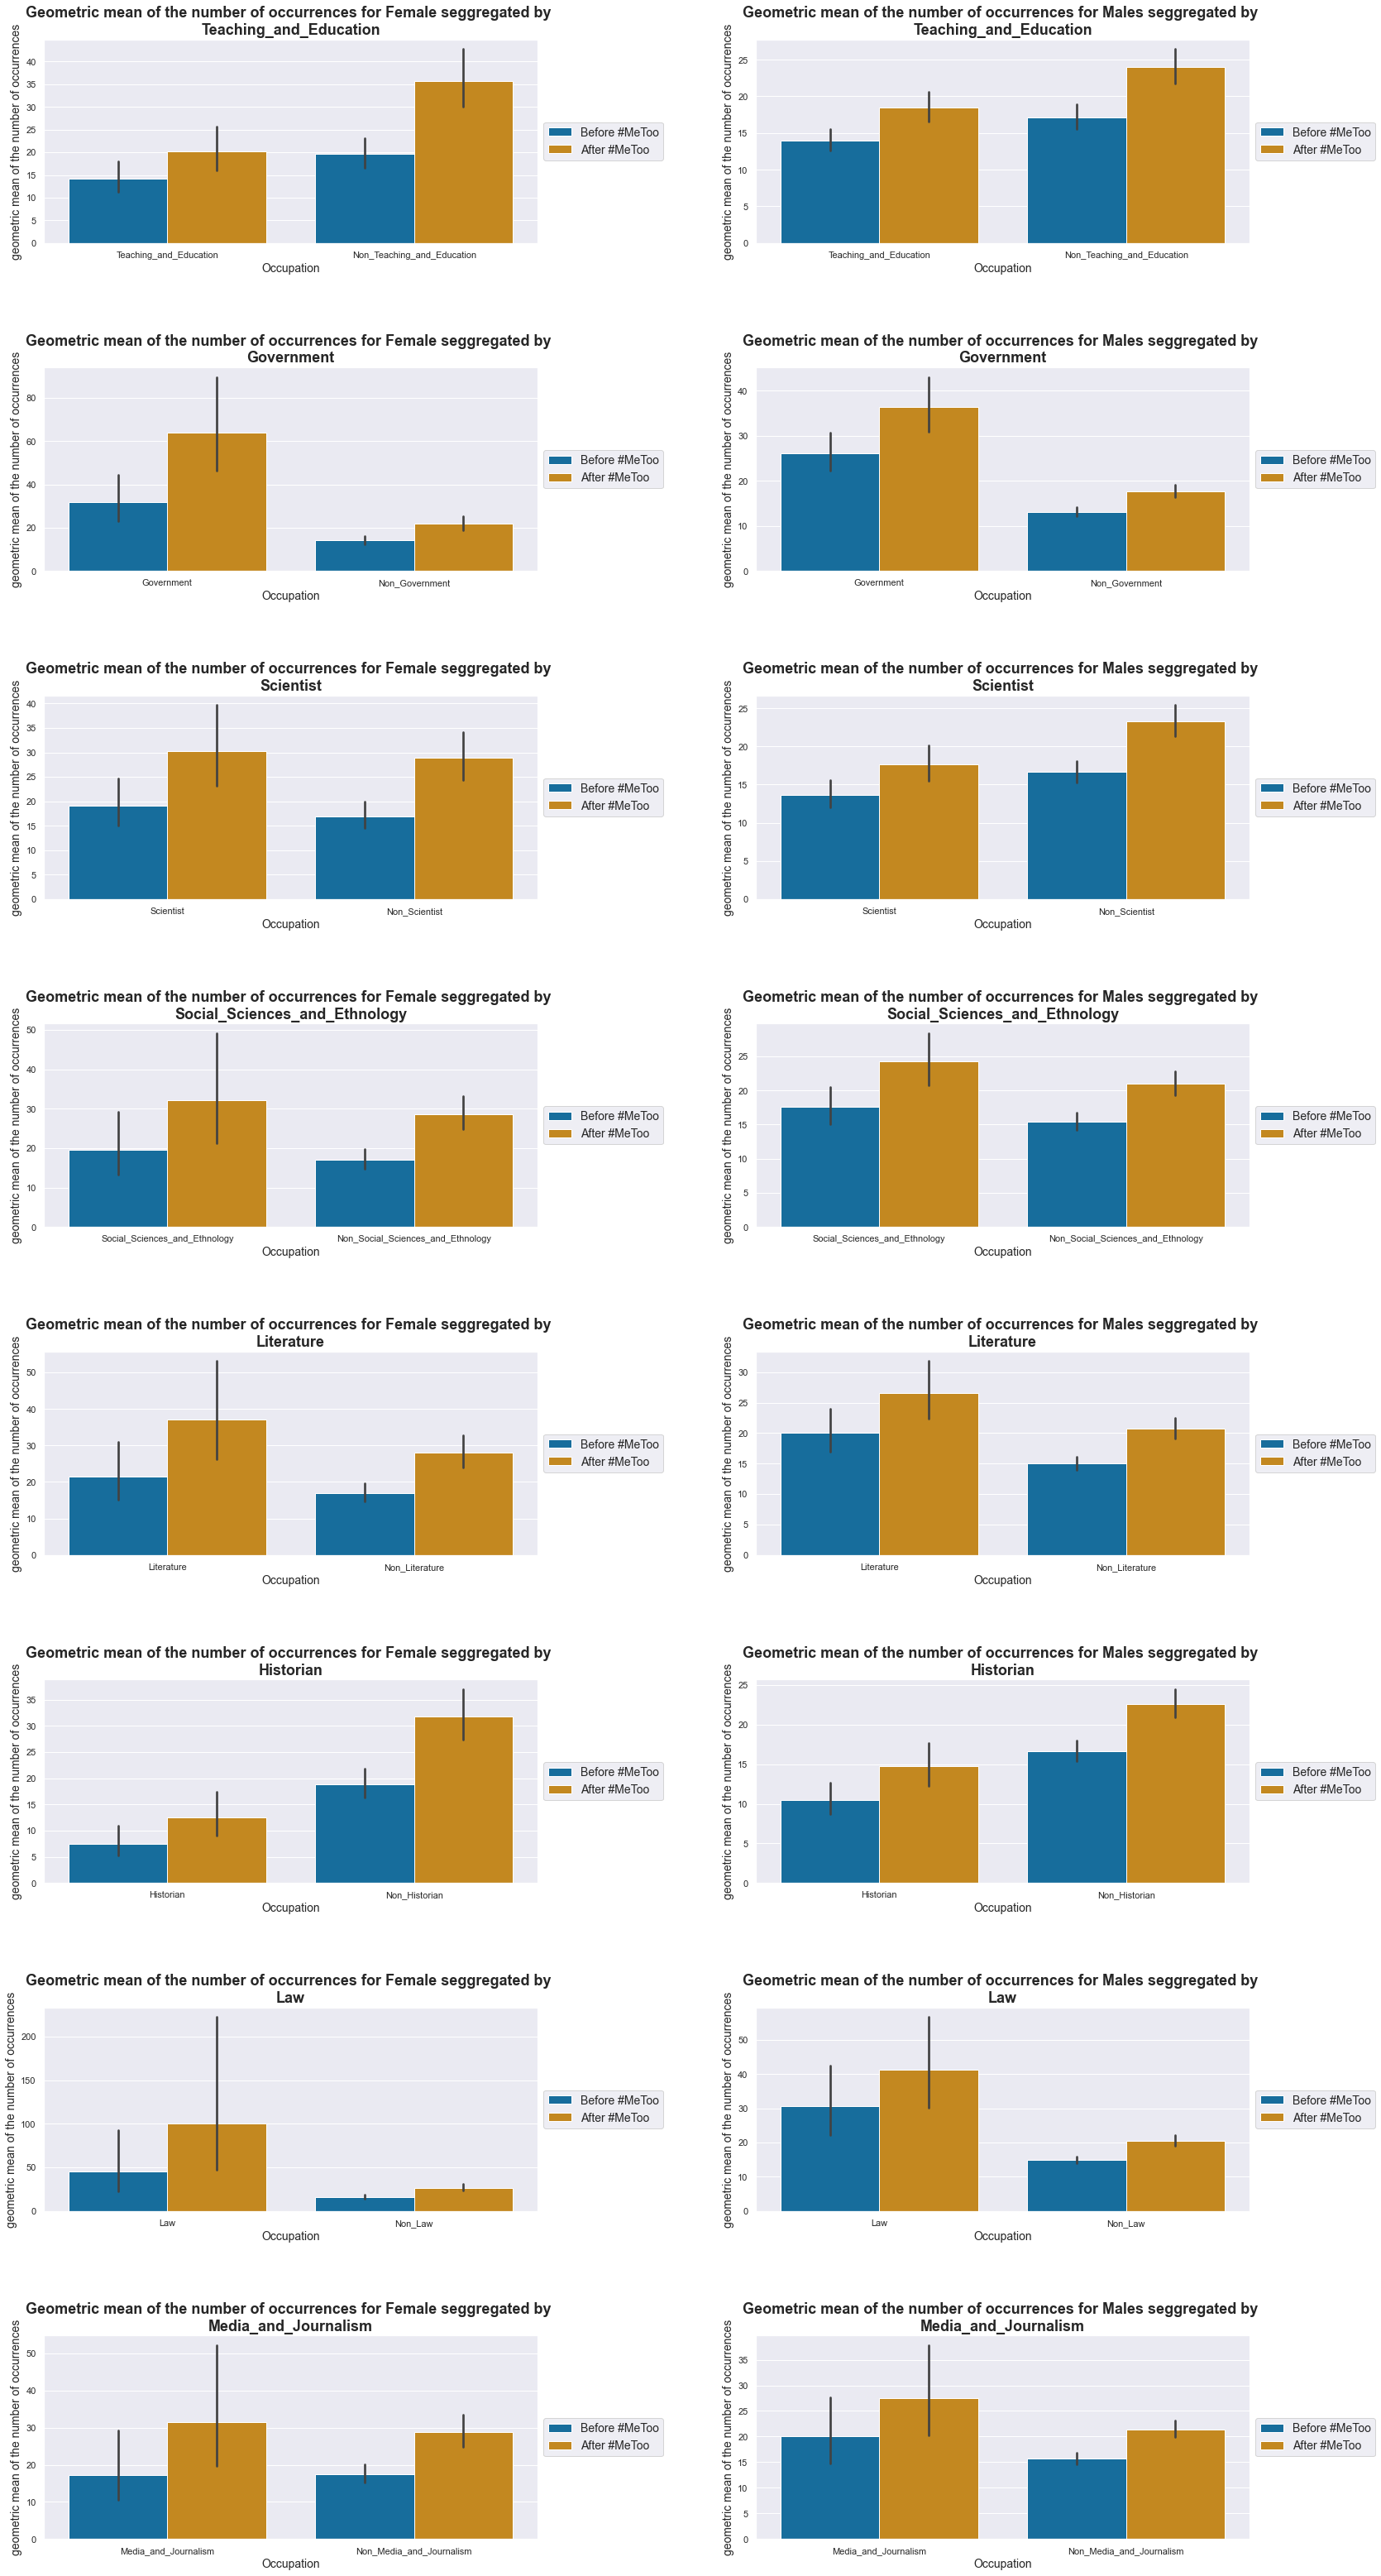

In [138]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0
for f in fulls:
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_occurrences', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_occurrences', hue = 'label', 
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('geometric mean of the number of occurrences',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Geometric mean of the number of occurrences for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('geometric mean of the number of occurrences',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Geometric mean of the number of occurrences for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    i+=1

#### Median of the number of occurences per occupation and per gender


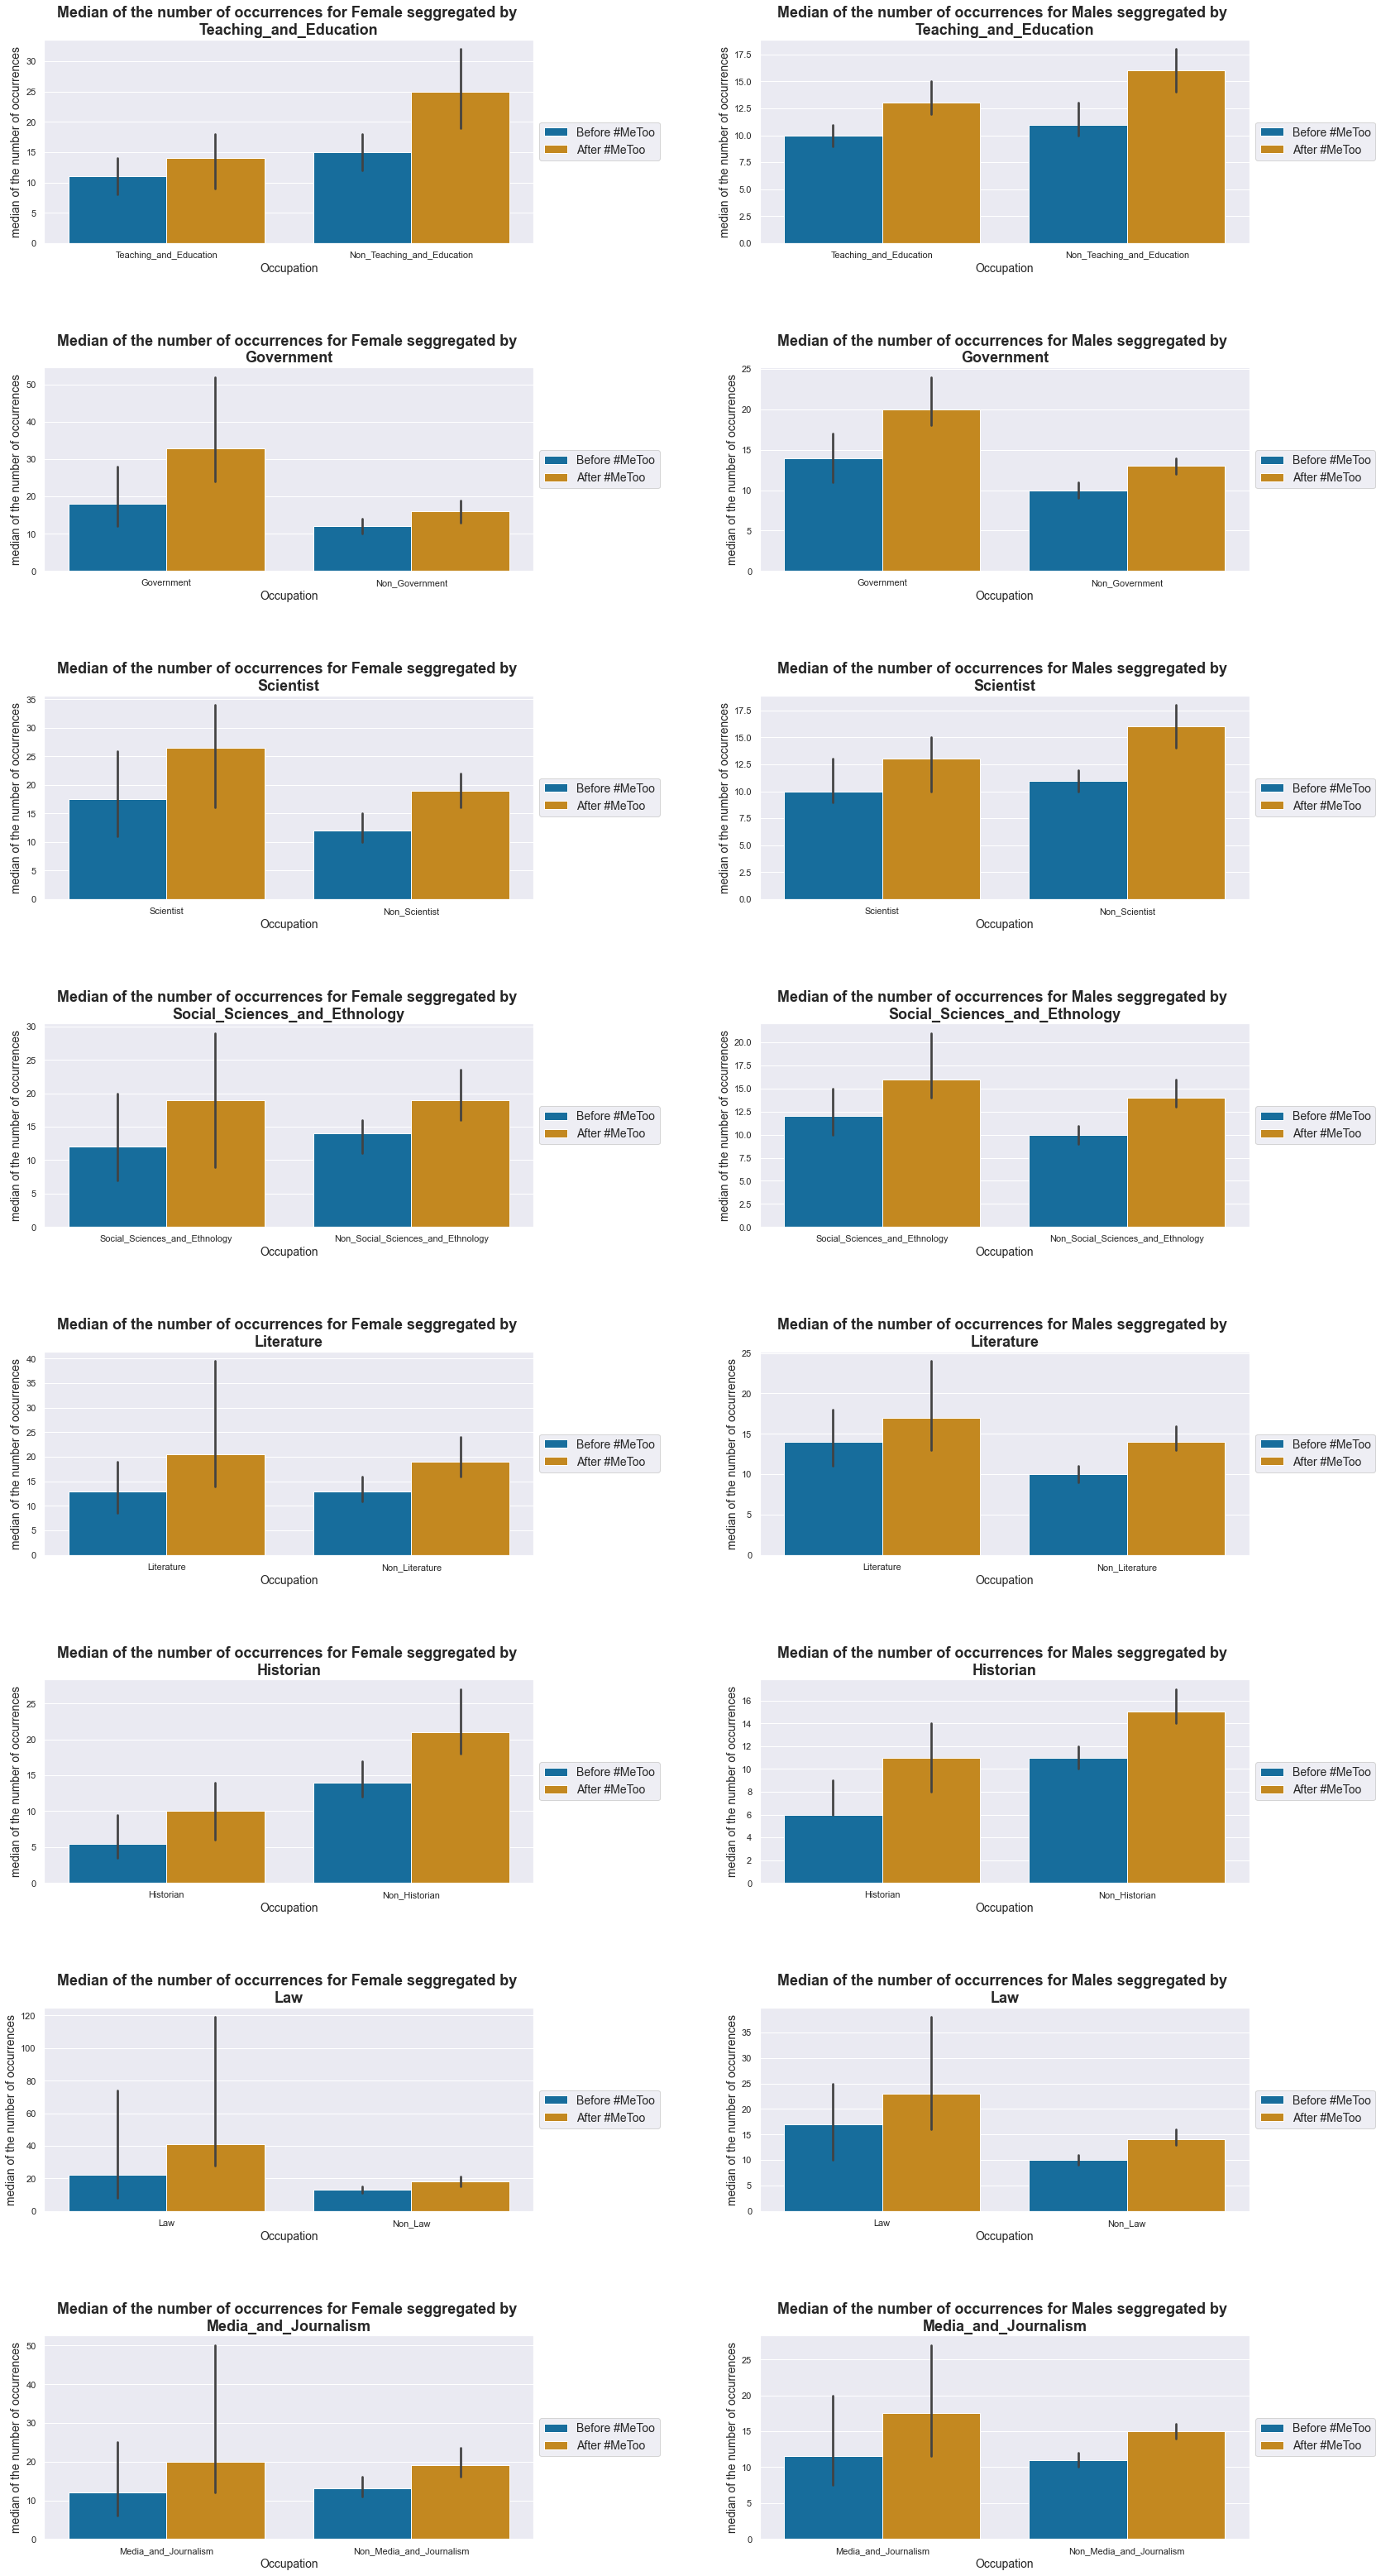

In [139]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=False, figsize=(25, 45));
i=0

for f in fulls:
    
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_occurrences', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "female")], estimator=np.median,n_boot=10000);
    
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_occurrences', hue = 'label',
                hue_order = ['Before #MeToo', 'After #MeToo'],
                data = f[(f['gender'] == "male")], estimator=np.median,n_boot=10000);
    
    fig.tight_layout(pad=6.0)
    
    ax[i,0].set_ylabel('median of the number of occurrences',fontsize=14);
    ax[i,0].set_xlabel("Occupation",fontsize=14)
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,0].set_title('Median of the number of occurrences for Female seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");

    
    ax[i,1].set_ylabel('median of the number of occurrences',fontsize=14);
    ax[i,1].set_xlabel("Occupation",fontsize=14)
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14);
    ax[i,1].set_title('Median of the number of occurrences for Males seggregated by \n'+cat_names[i],
                      fontsize=18,fontweight="bold");
    i+=1


#### Statistical tests by both occupation and gender
Let's see if these differences in median number of quotes is significant for every occupation and for every gender. Here again, we use the Wilcoxon signed-rank test. In this case, we will perform this test: once for female and once for male speakers, for every category of occupation. In each case, the null hypothesis is that the median of the population differences (between before and after #MeToo) is zero. The alternative hypothesis is that it is not.

In [140]:
def wilcoxon_by_category(c, name, non_name):
    df_wilcox = create_dF_category(c, name, non_name)
    df_wilcox_cat  = df_wilcox[df_wilcox['Occupation'] == name]
    df_wilcox_non_cat = df_wilcox[df_wilcox['Occupation'] == non_name]

    #Male, occ = yes
    male_diff_occ = pingouin.wilcoxon(df_wilcox_cat[(df_wilcox_cat['label'] == 1) & 
                                                    (df_wilcox_cat['gender'] == 'male')]['nb_quotes'], 
                                      df_wilcox_cat[(df_wilcox_cat['label'] == 0) & 
                                                    (df_wilcox_cat['gender'] == 'male')]['nb_quotes'])
    male_diff_occ['gender'] = 'male'
    male_diff_occ['Occupation'] = name

    #Male, occ = no
    male_diff_non_occ = pingouin.wilcoxon(df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 1) & 
                                                    (df_wilcox_non_cat['gender'] == 'male')]['nb_quotes'], 
                                      df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 0) & 
                                                    (df_wilcox_non_cat['gender'] == 'male')]['nb_quotes'])
    male_diff_non_occ['gender'] = 'male'
    male_diff_non_occ['Occupation'] = non_name


    #Female, occ = yes
    female_diff_occ = pingouin.wilcoxon(df_wilcox_cat[(df_wilcox_cat['label'] == 1) & 
                                                    (df_wilcox_cat['gender'] == 'female')]['nb_quotes'], 
                                      df_wilcox_cat[(df_wilcox_cat['label'] == 0) & 
                                                    (df_wilcox_cat['gender'] == 'female')]['nb_quotes'])
    female_diff_occ['gender'] = 'female'
    female_diff_occ['Occupation'] = name

    #Female, occ = no
    female_diff_non_occ = pingouin.wilcoxon(df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 1) & 
                                                    (df_wilcox_non_cat['gender'] == 'female')]['nb_quotes'], 
                                      df_wilcox_non_cat[(df_wilcox_non_cat['label'] == 0) & 
                                                    (df_wilcox_non_cat['gender'] == 'female')]['nb_quotes'])
    female_diff_non_occ['gender'] = 'female'
    female_diff_non_occ['Occupation'] = non_name


    return pd.concat([male_diff_occ, male_diff_non_occ, 
               female_diff_occ, female_diff_non_occ]).set_index(['gender', 'Occupation'])

In [141]:
wilcoxon = []
for c, name, non_name in zip(cat, cat_names, cat_non_names):
    wilcoxon.append(wilcoxon_by_category(c, name, non_name))

wilcoxon_results = pd.concat(wilcoxon)
wilcoxon_results

W-val alternative         p-val  \
gender Occupation                                                               
male   Teaching_and_Education              279379.0   two-sided  6.004361e-28   
       Non_Teaching_and_Education          622657.5   two-sided  1.875376e-54   
female Teaching_and_Education               13224.5   two-sided  4.259009e-09   
       Non_Teaching_and_Education           47631.5   two-sided  1.842059e-27   
male   Government                          141091.5   two-sided  3.534825e-20   
       Non_Government                      872094.5   two-sided  1.427405e-63   
female Government                            7037.0   two-sided  4.723549e-13   
       Non_Government                       62843.5   two-sided  1.169607e-23   
male   Scientist                           107983.5   two-sided  1.706968e-19   
       Non_Scientist                       958879.5   two-sided  4.671387e-64   
female Scientist                             7181.5   two-sided  5.226120e-07   
       Non_Scientist                        60630.5   two-sided  1.751798e-30   
male   Social_Sciences_and_Ethnology        72748.5   two-sided  2.054758e-22   
       Non_Social_Sciences_and_Ethnology  1096211.5   two-sided  1.066986e-61   
female Social_Sciences_and_Ethnology         1546.5   two-sided  1.371900e-09   
       Non_Social_Sciences_and_Ethnology    84809.0   two-sided  1.271300e-27   
male   Literature                           58775.0   two-sided  4.318169e-17   
       Non_Literature                     1152177.5   two-sided  8.129368e-67   
female Literature                            3431.0   two-sided  1.658095e-08   
       Non_Literature                       71329.0   two-sided  1.197125e-28   
male   Historian                            20466.0   two-sided  2.123748e-10   
       Non_Historian                      1365867.0   two-sided  6.142441e-74   
female Historian                             1023.0   two-sided  4.147549e-03   
       Non_Historian                        88002.0   two-sided  2.288786e-34   
male   Law                                  15096.0   two-sided  2.657791e-05   
       Non_Law                            1405199.0   two-sided  5.195274e-79   
female Law                                    507.5   two-sided  1.671034e-03   
       Non_Law                              96649.0   two-sided  9.577980e-33   
male   Media_and_Journalism                  6769.5   two-sided  6.212406e-05   
       Non_Media_and_Journalism           1504038.5   two-sided  1.467305e-78   
female Media_and_Journalism                  1011.5   two-sided  6.262404e-02   
       Non_Media_and_Journalism             88240.5   two-sided  1.296956e-35   

                                               RBC      CLES  
gender Occupation                                             
male   Teaching_and_Education             0.349302  0.557694  
       Non_Teaching_and_Education         0.397689  0.562646  
female Teaching_and_Education             0.394205  0.551703  
       Non_Teaching_and_Education         0.503554  0.584745  
male   Government                         0.348179  0.557440  
       Non_Government                     0.396141  0.561861  
female Government                         0.532968  0.589252  
       Non_Government                     0.445827  0.567682  
male   Scientist                          0.363072  0.560360  
       Non_Scientist                      0.389496  0.561720  
female Scientist                          0.392762  0.550552  
       Non_Scientist                      0.501503  0.582310  
male   Social_Sciences_and_Ethnology      0.421931  0.557330  
       Non_Social_Sciences_and_Ethnology  0.372051  0.561958  
female Social_Sciences_and_Ethnology      0.619464  0.582793  
       Non_Social_Sciences_and_Ethnology  0.448791  0.573102  
male   Literature                         0.389382  0.553865  
       Non_Literature                     0.381395  0.563598  
female Literature              

For more details on rank biserial correlation (RBC) and on common language effect size (CLES), please refer to the section [Statistical tests by gender](#Statistical-tests-by-gender).

In [142]:
alpha = 0.05
non_significant_results = wilcoxon_results[wilcoxon_results['p-val'] > alpha]
significant_results = wilcoxon_results[wilcoxon_results['p-val'] < alpha]
non_significant_results

,,W-val,alternative,p-val,RBC,CLES
gender,Occupation,,,,,
female,Media_and_Journalism,1011.5,two-sided,0.062624,0.251018,0.5697


We observe that the only non significant result we obtain (at a level $\alpha = 0.05$) is for female working in medias and journalism. There is no difference in their median number of occurrences before and after the movement.

However, for all other pairs of speakers before and after the movement we obtain a significant difference in the median number of quotes. These results are again non only seen for female speakers, but also for male speakers. Let's take a look at the directionality of the effect.

In [143]:
speakers_more_before = significant_results[significant_results['CLES'] < 0.5]
print('For',speakers_more_before.shape[0], 'gender/occupation combination, the speaker in the pair having a higher probability to speak is the one speaking before the movement.')

For 0 gender/occupation combination, the speaker in the pair having a higher probability to speak is the one speaking before the movement.


We obtain significant results for almost all combinations of gender/occupation. In each case, when looking at a pair of speakers, the one having the higher probability to be the "bigger speaker" is the one speaking after the movement. But the wilcoxon test tend to give significant results even if the effect sizes are small. Let's take a look at them.

In [144]:
medium_effect_size = significant_results[significant_results['CLES'] > 0.6]

In [145]:
medium_effect_size

,,W-val,alternative,p-val,RBC,CLES
gender,Occupation,,,,,
female,Historian,1023.0,two-sided,0.004148,0.368519,0.609857


The only significant result we obtain, combined with a medium effect size (common language effect size bigger than 0.6) is for the historian women. For all others combination of gender/occupation, even if the p-value obtained is small, the effect size is also small (CLES < 0.6). 

**Conclusion:** #TODO on en conclut que qui parle plus dans quelle catégorie?

## Discussion

### Matching assessment

In this section, we assess the performance of the matching from part [Matching by gender](#Matching-by-gender). To do so, we check for all match pairs the number of common categorical features and the number of different categorical features. We also compute the absolute age difference.

In [146]:
with open(DATA_FOLDER_RESULT + 'matching_by_gender.txt') as f:
    lines = f.readlines()

In [147]:
lines = [line[1:-2] for line in lines]


In [148]:
pairs = [line.split(', ') for line in lines]
pairs = [[int(pair[0]), int(pair[1])] for pair in pairs]

In [149]:
def order_pair(pair):
    if speakers_once.loc[pair[0]].label == 0:
        return pair
    else:
        return [pair[1], pair[0]]

In [150]:
ordered_pairs = []
for pair in pairs: 
    ordered_pairs.append(order_pair(pair))

In [151]:
pair_before = [pair[0] for pair in ordered_pairs]
pair_after = [pair[1] for pair in ordered_pairs]

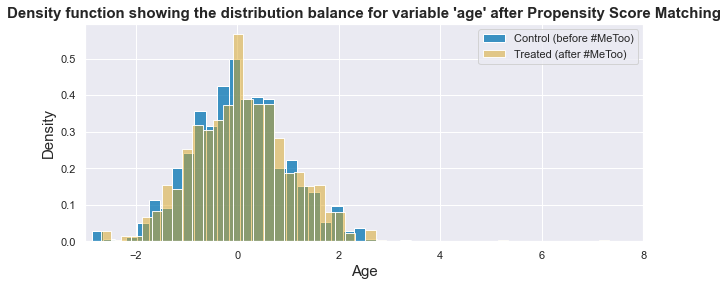

In [152]:
sns.histplot(speakers_once.loc[pair_before,:]['age'], stat = 'density', bins = 50)
sns.histplot(speakers_once.loc[pair_after,:]['age'], stat = 'density', color = 'goldenrod', alpha = 0.5, bins = 50)
plt.legend(labels=['Control (before #MeToo)', 'Treated (after #MeToo)']);
plt.xlim([-3,8])
plt.title("Density function showing the distribution balance for variable 'age' after Propensity Score Matching", 
          fontweight = 'bold', fontsize = 15);
plt.ylabel("Density", fontsize = 15)
plt.xlabel("Age", fontsize = 15);

In [153]:
def check_pair(pair):
    sum_features = speakers_once.loc[pair,:].drop(['speaker', 'qids', 'gender', 'nb_quotes', 'nb_occurrences', 'label', 'age', 'Propensity_score'], axis = 1).sum()
    count = Counter(sum_features.values)
    nb_common_cat_features = count[0] + count[2]
    nb_diff_cat_features = count[1]
    diff_age = speakers_once.loc[pair[0]]['age'] - speakers_once.loc[pair[1]]['age']
    return [nb_common_cat_features, nb_diff_cat_features, diff_age]


In [154]:
similarity_pairs = []
for pair in pairs:
    similarity_pairs.append(check_pair(pair))

df_similarity = pd.DataFrame(similarity_pairs, columns = ['Number of common features', 'Number of different features', 
                                          'Difference in age'])


In [155]:
df_similarity.sample(2)

,Number of common features,Number of different features,Difference in age
1234,38,2,-1.70079
791,38,2,-0.24297


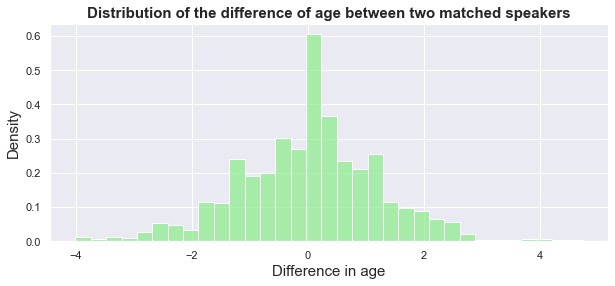

In [156]:
sns.histplot(data = df_similarity['Difference in age'], stat = 'density', color = 'lightgreen')
plt.title('Distribution of the difference of age between two matched speakers', 
         fontweight = 'bold', fontsize = 15);
plt.xlabel('Difference in age', fontsize = 15)
plt.ylabel('Density', fontsize = 15);

In [157]:
x = Counter(df_similarity['Number of common features']).keys()
y = Counter(df_similarity['Number of common features']).values()

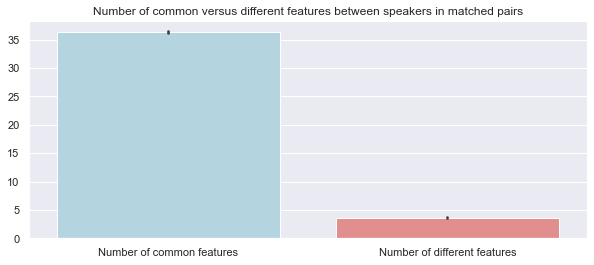

In [158]:
sns.barplot(data = df_similarity.drop(['Difference in age'], axis = 1), 
                    palette = ['lightblue','lightcoral'])
plt.title('Number of common versus different features between speakers in matched pairs');

In [159]:
print('Mean number of common categorical features between speakers of a pair', 
      "{:.2f}".format(df_similarity['Number of common features'].mean()))
print('Mean number of different categorical features between speakers of a pair',
      "{:.2f}".format(df_similarity['Number of different features'].mean()))

Mean number of common categorical features between speakers of a pair 36.35
Mean number of different categorical features between speakers of a pair 3.65


In [160]:
print('We had', len(pairs), 'pairs of speakers, matched thanks to the propensity score and matching method.')
print('We had', round(speakers_twice.shape[0]/2), 'pairs of speakers already matched since they are composed of the same person.')

We had 1259 pairs of speakers, matched thanks to the propensity score and matching method.
We had 3363 pairs of speakers already matched since they are composed of the same person.


We can tell with certainty that for 3363 pairs of speakers, the matching was almost perfect: speakers in the pair are exaclty identical expect for the age that is bigger from approximatly 3 years for the treated speaker. For the remaining 1259 pairs, we see from the two plots above that 
- the mean number of similar categorical features between speakers in a pair is around 36.35
- the mean number of different categorical features between speakers in a pair is around 3.65
- the distribution of the difference of age is normally ditributed around 0

Thus, since the number of similar categorical features between speakers in a pair is much higher than the number of different features, and that the difference of the continuous variable is ditributed around 0, we conclude that the [matching](#Matching-by-gender) performed  if fairly good, since we wanted to pair identical speakers in term of osbervable covariates. However, the pseudo $R^2$ obtained in the [logistic regression](#Propensity-score-calculation) is not very high $(0.01480)$, and for future work it might be useful to include more features in the regression than what we did. 

Since the next [matchings](#Matching-by-category-of-occupation) have been done based on the same propensity scores and using the same algorithm, we do not repeat the assessment procedure and we assume that the results should be approximately the same.

## Conclusion

IDEES
- il y a plus d'hommes qui parlent (cf descriptive tasks)
- par contre terme de quotes/speaker, les femmes parlent plus
- tout le monde parle plus après #MeToo: la différence est a peine plus grande pour les femmes
- toutes les occupations parlent plus après #MeToo, hommes et femmes confondus, sauf les femmes de Media and Journalism mais effet pas très grand sauf assez grand pour les femmes historiennes!
- conclu: 
    - effet peut etre moins grand que ce a quoi on s'attendait
    - pourquoi tout le monde parle plus après MeToo? Should be investigated in future work maybe
- ouverture: est ce vraiment lié au mouvement MeToo ou juste à une évolution générale ? Nos fenêtres de temps sont trop longues pour affirmer que c'est vraiment avec MeToo...